In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
import random
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "centralized training_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.01,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.05, transfer_ratio= 0.4):
    trainloader = []
    valloader = []
    traindata_list = []
    trainlabel_list = []
    valdata_list = []
    vallabel_list = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        test_ratio = 1 - (train_ratio + val_ratio)
        print(test_ratio)
        test_size = int(test_ratio * len(dataset))
        print(test_size)
        transfer_size = int((len(dataset) - test_size)*transfer_ratio)
        train_size_t = int(train_ratio * transfer_size)
        val_size_t = transfer_size - train_size_t
        centralized_size = len(dataset) - (transfer_size + test_size)
        train_size = int(centralized_size * train_ratio)
        val_size = centralized_size - train_size
        print(f"client {i}")
        print(f"train size = {train_size}")
        print(f"validation size = {val_size}")
        print(f"test set = {test_size}")
        print(f"train transfer size = {train_size_t}")
        print(f"validation transfer size = {val_size_t}")
        train_dataset, val_dataset, test_dataset, train_dataset_transfer, val_dataset_transfer = random_split(dataset, [train_size, val_size, test_size, train_size_t, val_size_t])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))

        traindata_list.append(train_dataset_transfer.dataset.tensors[0][train_dataset_transfer.indices])
        trainlabel_list.append(train_dataset_transfer.dataset.tensors[1][train_dataset_transfer.indices])
        valdata_list.append(val_dataset_transfer.dataset.tensors[0][val_dataset_transfer.indices])
        vallabel_list.append(val_dataset_transfer.dataset.tensors[1][val_dataset_transfer.indices])
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    traindata = torch.cat(traindata_list, dim=0)
    trainlabels = torch.cat(trainlabel_list, dim=0)
    valdata = torch.cat(valdata_list, dim=0)
    vallabels = torch.cat(vallabel_list, dim=0)
    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    trainloader_transfer = DataLoader(TensorDataset(traindata, trainlabels), batch_size=batch_size, shuffle=False)
    valloader_transfer = DataLoader(TensorDataset(valdata, vallabels), batch_size=batch_size, shuffle=False)
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, name):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        wandb.log({f'{name} training accuracy': train_acc,
                   f'{name} validationaccuracy': test_acc})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()
def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 51.0036506652832 Testing accuracy: 53.284671783447266.

Epoch 2/100
Epoch 2: Training accuracy: 56.84306716918945 Testing accuracy: 49.63503646850586.

Epoch 3/100
Epoch 3: Training accuracy: 63.22992706298828 Testing accuracy: 55.47445297241211.

Epoch 4/100
Epoch 4: Training accuracy: 72.35401153564453 Testing accuracy: 64.23357391357422.

Epoch 5/100
Epoch 5: Training accuracy: 75.54744720458984 Testing accuracy: 64.9635009765625.

Epoch 6/100
Epoch 6: Training accuracy: 78.37591552734375 Testing accuracy: 68.6131362915039.

Epoch 7/100
Epoch 7: Training accuracy: 79.37956237792969 Testing accuracy: 65.69342803955078.

Epoch 8/100
Epoch 8: Training accuracy: 83.12043762207031 Testing accuracy: 72.26277160644531.

Epoch 9/100
Epoch 9: Training accuracy: 84.39781188964844 Testing accuracy: 73.72262573242188.

Epoch 10/100
Epoch 10: Training accuracy: 81.29562377929688 Testing accuracy: 75.91240692138672.

Epoch 11/100
Epoch 11: Training accurac

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


centralized training accuracy,▁▃▅▆▆▆▇▇▇███▇███████████████████████████
centralized validationaccuracy,▁▁▄▅▅▅▇▆▇▇▇▇▆▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇███▆█▇▇▇█▇█
centralized training accuracy,98.26643
centralized validationaccuracy,84.67153


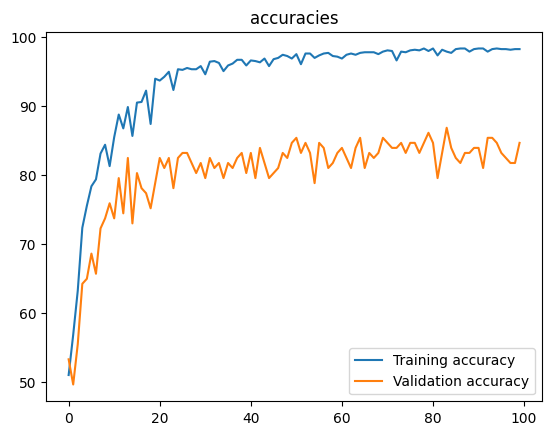

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, valloader, configuration, configuration['epochs'], name= 'centralized')
    loss, accuracy = test(net, testloader, configuration)
    print(f"Epoch {epoch+1}: Test loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

# Federated Learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

0.1499999999999999
250
client 0
train size = 681
validation size = 171
test set = 250
train transfer size = 454
validation transfer size = 114
0.1499999999999999
233
client 1
train size = 637
validation size = 160
test set = 233
train transfer size = 424
validation transfer size = 106
0.1499999999999999
310
client 2
train size = 844
validation size = 212
test set = 310
train transfer size = 563
validation transfer size = 141
0.1499999999999999
253
client 3
train size = 690
validation size = 173
test set = 253
train transfer size = 459
validation transfer size = 115


In [8]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FL unified",
    name= "federated learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config=configuration
)


/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [9]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [10]:
def train_FL(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()


In [11]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [13]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-18 20:43:27,813	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 49327849881.0, 'CPU': 32.0, 'node:192.168.1.146': 1.0, 'memory': 105098316391.0, 'accelerator_type:G': 1.0, 'GPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.04324009137995103 / accuracy 49.52198791503906
(ClientAppActor pid=1208103) 
(ClientAppActor pid=1208103) Epoch 1/100
(ClientAppActor pid=1208102) Epoch 1: Training accuracy: 48.665618896484375 Testing accuracy: 51.25.
(ClientAppActor pid=1208102) Epoch 2: Training accuracy: 51.334381103515625 Testing accuracy: 48.75.
(ClientAppActor pid=1208102) Epoch 3: Training accuracy: 51.334381103515625 Testing accuracy: 48.75.
(ClientAppActor pid=1208102) Epoch 4: Training accuracy: 51.334381103515625 Testing accuracy: 48.75.
(ClientAppActor pid=1208102) Epoch 5: Training accuracy: 50.86342239379883 Testing accuracy: 50.0.
(ClientAppActor pid=1208102) Epoch 6: Training accuracy: 51.334381103515625 Testing accuracy: 48.75.
(ClientAppActor pid=1208102) Epoch 7: Training accuracy: 51.334381103515625 Testing accuracy: 48.75.
(ClientAppActor pid=1208102) Epoch 8: Training accuracy: 51.334381103515625 Testing accuracy: 48.75.
(ClientAppActor pid=1208102) Epoch 9: Training

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.041565782883588004, {'accuracy': tensor(50.4780, device='cuda:0')}, 44.15287465399888)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.041565782883588004 / accuracy 50.47801208496094


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 18x across cluster]
(ClientAppActor pid=1208103) Epoch 8/100 [repeated 18x across cluster]
(ClientAppActor pid=1208102) Epoch 10: Training accuracy: 69.13043212890625 Testing accuracy: 69.3641586303711. [repeated 18x across cluster]
(ClientAppActor pid=1208103)  [repeated 29x across cluster]
(ClientAppActor pid=1208103) Epoch 19/100 [repeated 29x across cluster]
(ClientAppActor pid=1208102) Epoch 28: Training accuracy: 75.65217590332031 Testing accuracy: 75.1445083618164. [repeated 29x across cluster]
(ClientAppActor pid=1208102)  [repeated 39x across cluster]
(ClientAppActor pid=1208102) Epoch 54/100 [repeated 39x across cluster]
(ClientAppActor pid=1208103) Epoch 31: Training accuracy: 54.038177490234375 Testing accuracy: 54.970760345458984. [repeated 38x across cluster]
(ClientAppActor pid=1208103)  [repeated 41x across cluster]
(ClientAppActor pid=1208103) Epoch 49/100 [repeated 41x across cluster]
(ClientAppActor pid=1208103) Epoch 48: Train

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.03472979980356553, {'accuracy': tensor(65.3920, device='cuda:0')}, 88.30187314600335)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03472979980356553 / accuracy 65.3919677734375


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 37x across cluster]
(ClientAppActor pid=1208102) Epoch 2/100 [repeated 37x across cluster]
(ClientAppActor pid=1208102) Epoch 1: Training accuracy: 74.05213165283203 Testing accuracy: 70.28302001953125. [repeated 37x across cluster]
(ClientAppActor pid=1208103)  [repeated 39x across cluster]
(ClientAppActor pid=1208103) Epoch 13/100 [repeated 39x across cluster]
(ClientAppActor pid=1208103) Epoch 12: Training accuracy: 77.82672882080078 Testing accuracy: 76.60818481445312. [repeated 38x across cluster]
(ClientAppActor pid=1208103)  [repeated 30x across cluster]
(ClientAppActor pid=1208103) Epoch 24/100 [repeated 30x across cluster]
(ClientAppActor pid=1208103) Epoch 23: Training accuracy: 73.56828308105469 Testing accuracy: 71.92982482910156. [repeated 30x across cluster]
(ClientAppActor pid=1208103)  [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 35/100 [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 34: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.03279493486180025, {'accuracy': tensor(72.2753, device='cuda:0')}, 147.45727477299806)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03279493486180025 / accuracy 72.27533721923828


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 8/100 [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 7: Training accuracy: 76.23188781738281 Testing accuracy: 73.98844146728516. [repeated 32x across cluster]
(ClientAppActor pid=1208102)  [repeated 37x across cluster]
(ClientAppActor pid=1208102) Epoch 35/100 [repeated 37x across cluster]
(ClientAppActor pid=1208102) Epoch 34: Training accuracy: 74.74302673339844 Testing accuracy: 71.92982482910156. [repeated 37x across cluster]
(ClientAppActor pid=1208102)  [repeated 24x across cluster]
(ClientAppActor pid=1208102) Epoch 49/100 [repeated 24x across cluster]
(ClientAppActor pid=1208102) Epoch 48: Training accuracy: 82.37885284423828 Testing accuracy: 76.60818481445312. [repeated 24x across cluster]
(ClientAppActor pid=1208103)  [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 46/100 [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 45: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.03255872866686653, {'accuracy': tensor(73.4226, device='cuda:0')}, 222.39692576200468)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03255872866686653 / accuracy 73.42256164550781
(ClientAppActor pid=1208103)  [repeated 34x across cluster]
(ClientAppActor pid=1208103) Epoch 2/100 [repeated 34x across cluster]
(ClientAppActor pid=1208103) Epoch 1: Training accuracy: 72.2748794555664 Testing accuracy: 65.5660400390625. [repeated 33x across cluster]
(ClientAppActor pid=1208102)  [repeated 145x across cluster]
(ClientAppActor pid=1208102) Epoch 37/100 [repeated 145x across cluster]
(ClientAppActor pid=1208102) Epoch 36: Training accuracy: 83.3594970703125 Testing accuracy: 78.75. [repeated 145x across cluster]
(ClientAppActor pid=1208103)  [repeated 61x across cluster]
(ClientAppActor pid=1208103) Epoch 35/100 [repeated 61x across cluster]
(ClientAppActor pid=1208103) Epoch 34: Training accuracy: 83.8862533569336 Testing accuracy: 76.41509246826172. [repeated 61x across cluster]
(ClientAppActor pid=1208102)  [repeated 64x across cluster]
(ClientAppActor pid=1208102) Epoch 32/100 [repeated 6

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.03170698881149292, {'accuracy': tensor(75.0478, device='cuda:0')}, 253.21213522700418)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03170698881149292 / accuracy 75.04779815673828
(ClientAppActor pid=1208102)  [repeated 17x across cluster]
(ClientAppActor pid=1208102) Epoch 1/100 [repeated 17x across cluster]
(ClientAppActor pid=1208103) Epoch 100: Training accuracy: 79.3838882446289 Testing accuracy: 71.69811248779297. [repeated 17x across cluster]
(ClientAppActor pid=1208102)  [repeated 37x across cluster]
(ClientAppActor pid=1208102) Epoch 20/100 [repeated 37x across cluster]
(ClientAppActor pid=1208102) Epoch 19: Training accuracy: 82.4637680053711 Testing accuracy: 76.87861633300781. [repeated 36x across cluster]
(ClientAppActor pid=1208103)  [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 27/100 [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 26: Training accuracy: 83.53080749511719 Testing accuracy: 77.35848999023438. [repeated 24x across cluster]
(ClientAppActor pid=1208102)  [repeated 32x across cluster]
(ClientAppActor pid=1208102) Epoch 57/10

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.03257578260758344, {'accuracy': tensor(74.1874, device='cuda:0')}, 327.5982695190032)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03257578260758344 / accuracy 74.1873779296875


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 21x across cluster]
(ClientAppActor pid=1208102) Epoch 10/100 [repeated 21x across cluster]
(ClientAppActor pid=1208102) Epoch 9: Training accuracy: 81.27961730957031 Testing accuracy: 75.94339752197266. [repeated 20x across cluster]
(ClientAppActor pid=1208102)  [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 38/100 [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 37: Training accuracy: 83.6492919921875 Testing accuracy: 76.41509246826172. [repeated 43x across cluster]
(ClientAppActor pid=1208103)  [repeated 226x across cluster]
(ClientAppActor pid=1208103) Epoch 35/100 [repeated 226x across cluster]
(ClientAppActor pid=1208103) Epoch 34: Training accuracy: 82.52569580078125 Testing accuracy: 76.02339172363281. [repeated 226x across cluster]
(ClientAppActor pid=1208103)  [repeated 74x across cluster]
(ClientAppActor pid=1208103) Epoch 59/100 [repeated 74x across cluster]
(ClientAppActor pid=1208103) Epoch 58: Tra

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.03150271668153651, {'accuracy': tensor(75.4302, device='cuda:0')}, 356.23888259299565)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03150271668153651 / accuracy 75.43021392822266


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 17x across cluster]
(ClientAppActor pid=1208103) Epoch 1/100 [repeated 17x across cluster]
(ClientAppActor pid=1208103) Epoch 100: Training accuracy: 84.43465423583984 Testing accuracy: 74.85379791259766. [repeated 17x across cluster]
(ClientAppActor pid=1208103)  [repeated 49x across cluster]
(ClientAppActor pid=1208103) Epoch 20/100 [repeated 49x across cluster]
(ClientAppActor pid=1208103) Epoch 19: Training accuracy: 82.96622467041016 Testing accuracy: 78.3625717163086. [repeated 48x across cluster]
(ClientAppActor pid=1208102)  [repeated 52x across cluster]
(ClientAppActor pid=1208102) Epoch 63/100 [repeated 52x across cluster]
(ClientAppActor pid=1208102) Epoch 62: Training accuracy: 86.7298583984375 Testing accuracy: 76.88679504394531. [repeated 52x across cluster]
(ClientAppActor pid=1208102)  [repeated 56x across cluster]
(ClientAppActor pid=1208102) Epoch 99/100 [repeated 56x across cluster]
(ClientAppActor pid=1208102) Epoch 98: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.03244777637369493, {'accuracy': tensor(73.0402, device='cuda:0')}, 389.3499053620035)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03244777637369493 / accuracy 73.04015350341797
(ClientAppActor pid=1208103)  [repeated 230x across cluster]
(ClientAppActor pid=1208103) Epoch 9/100 [repeated 230x across cluster]
(ClientAppActor pid=1208103) Epoch 8: Training accuracy: 81.16114044189453 Testing accuracy: 72.64151000976562. [repeated 229x across cluster]
(ClientAppActor pid=1208103)  [repeated 42x across cluster]
(ClientAppActor pid=1208103) Epoch 25/100 [repeated 42x across cluster]
(ClientAppActor pid=1208103) Epoch 24: Training accuracy: 84.47867584228516 Testing accuracy: 77.35848999023438. [repeated 42x across cluster]
(ClientAppActor pid=1208102)  [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 91/100 [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 90: Training accuracy: 87.24637603759766 Testing accuracy: 75.1445083618164. [repeated 42x across cluster]
(ClientAppActor pid=1208103)  [repeated 20x across cluster]
(ClientAppActor pid=1208103) Epoch 47/

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.030813203138463637, {'accuracy': tensor(74.7610, device='cuda:0')}, 440.0679098690016)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030813203138463637 / accuracy 74.76099395751953


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 20x across cluster]
(ClientAppActor pid=1208102) Epoch 7/100 [repeated 20x across cluster]
(ClientAppActor pid=1208102) Epoch 6: Training accuracy: 82.31884002685547 Testing accuracy: 76.30057525634766. [repeated 20x across cluster]
(ClientAppActor pid=1208103)  [repeated 28x across cluster]
(ClientAppActor pid=1208103) Epoch 19/100 [repeated 28x across cluster]
(ClientAppActor pid=1208103) Epoch 18: Training accuracy: 83.67346954345703 Testing accuracy: 78.75. [repeated 28x across cluster]
(ClientAppActor pid=1208103)  [repeated 26x across cluster]
(ClientAppActor pid=1208103) Epoch 32/100 [repeated 26x across cluster]
(ClientAppActor pid=1208103) Epoch 31: Training accuracy: 83.3594970703125 Testing accuracy: 78.125. [repeated 26x across cluster]
(ClientAppActor pid=1208102)  [repeated 28x across cluster]
(ClientAppActor pid=1208102) Epoch 53/100 [repeated 28x across cluster]
(ClientAppActor pid=1208102) Epoch 52: Training accuracy: 86.81159210

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.030676480601815617, {'accuracy': tensor(74.8566, device='cuda:0')}, 479.13559837099456)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 154x across cluster]
(ClientAppActor pid=1208102) Epoch 100/100 [repeated 154x across cluster]
(ClientAppActor pid=1208102) Epoch 100: Training accuracy: 86.7298583984375 Testing accuracy: 78.30188751220703. [repeated 156x across cluster]
Server-side evaluation loss 0.030676480601815617 / accuracy 74.85659790039062


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 63x across cluster]
(ClientAppActor pid=1208102) Epoch 52/100 [repeated 63x across cluster]
(ClientAppActor pid=1208102) Epoch 51: Training accuracy: 84.36019134521484 Testing accuracy: 76.41509246826172. [repeated 61x across cluster]
(ClientAppActor pid=1208102)  [repeated 47x across cluster]
(ClientAppActor pid=1208102) Epoch 89/100 [repeated 47x across cluster]
(ClientAppActor pid=1208102) Epoch 88: Training accuracy: 81.39810180664062 Testing accuracy: 75.94339752197266. [repeated 47x across cluster]
(ClientAppActor pid=1208102)  [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 19/100 [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 18: Training accuracy: 85.36231994628906 Testing accuracy: 76.30057525634766. [repeated 43x across cluster]
(ClientAppActor pid=1208103)  [repeated 42x across cluster]
(ClientAppActor pid=1208103) Epoch 44/100 [repeated 42x across cluster]
(ClientAppActor pid=1208103) Epoch 43: Trai

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.029574289041406968, {'accuracy': tensor(76.4818, device='cuda:0')}, 518.5840076680033)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.029574289041406968 / accuracy 76.4818344116211


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 90x across cluster]
(ClientAppActor pid=1208102) Epoch 45/100 [repeated 90x across cluster]
(ClientAppActor pid=1208102) Epoch 44: Training accuracy: 84.14442443847656 Testing accuracy: 80.625. [repeated 90x across cluster]
(ClientAppActor pid=1208102)  [repeated 319x across cluster]
(ClientAppActor pid=1208102) Epoch 67/100 [repeated 319x across cluster]
(ClientAppActor pid=1208102) Epoch 66: Training accuracy: 85.21739196777344 Testing accuracy: 72.83236694335938. [repeated 320x across cluster]
(ClientAppActor pid=1208102)  [repeated 28x across cluster]
(ClientAppActor pid=1208102) Epoch 95/100 [repeated 28x across cluster]
(ClientAppActor pid=1208102) Epoch 94: Training accuracy: 86.66666412353516 Testing accuracy: 73.41040802001953. [repeated 28x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.030545641394222483, {'accuracy': tensor(75.3346, device='cuda:0')}, 530.952972138999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030545641394222483 / accuracy 75.33460998535156


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 36x across cluster]
(ClientAppActor pid=1208103) Epoch 12/100 [repeated 36x across cluster]
(ClientAppActor pid=1208103) Epoch 11: Training accuracy: 84.28781127929688 Testing accuracy: 78.3625717163086. [repeated 35x across cluster]
(ClientAppActor pid=1208102)  [repeated 25x across cluster]
(ClientAppActor pid=1208102) Epoch 34/100 [repeated 25x across cluster]
(ClientAppActor pid=1208102) Epoch 33: Training accuracy: 86.3768081665039 Testing accuracy: 74.56647491455078. [repeated 25x across cluster]
(ClientAppActor pid=1208103)  [repeated 28x across cluster]
(ClientAppActor pid=1208103) Epoch 34/100 [repeated 28x across cluster]
(ClientAppActor pid=1208103) Epoch 33: Training accuracy: 83.84728240966797 Testing accuracy: 80.70175170898438. [repeated 28x across cluster]
(ClientAppActor pid=1208103)  [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 45/100 [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 44: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.030196274028104896, {'accuracy': tensor(76.2906, device='cuda:0')}, 601.7216741690063)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 100/100 [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 99: Training accuracy: 85.08634185791016 Testing accuracy: 80.625. [repeated 24x across cluster]
Server-side evaluation loss 0.030196274028104896 / accuracy 76.29063415527344


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 194x across cluster]
(ClientAppActor pid=1208103) Epoch 24/100 [repeated 194x across cluster]
(ClientAppActor pid=1208103) Epoch 23: Training accuracy: 84.43465423583984 Testing accuracy: 80.70175170898438. [repeated 193x across cluster]
(ClientAppActor pid=1208102)  [repeated 68x across cluster]
(ClientAppActor pid=1208102) Epoch 24/100 [repeated 68x across cluster]
(ClientAppActor pid=1208102) Epoch 23: Training accuracy: 86.66666412353516 Testing accuracy: 75.72254180908203. [repeated 68x across cluster]
(ClientAppActor pid=1208103)  [repeated 63x across cluster]
(ClientAppActor pid=1208103) Epoch 64/100 [repeated 63x across cluster]
(ClientAppActor pid=1208103) Epoch 63: Training accuracy: 85.46255493164062 Testing accuracy: 81.28655242919922. [repeated 63x across cluster]
(ClientAppActor pid=1208103)  [repeated 63x across cluster]
(ClientAppActor pid=1208103) Epoch 98/100 [repeated 63x across cluster]
(ClientAppActor pid=1208103) Epoch 97: T

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.03059246259577134, {'accuracy': tensor(75.5258, device='cuda:0')}, 626.3318509139935)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03059246259577134 / accuracy 75.52581024169922


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 13x across cluster]
(ClientAppActor pid=1208102) Epoch 1/100 [repeated 13x across cluster]
(ClientAppActor pid=1208102) Epoch 100: Training accuracy: 88.1159439086914 Testing accuracy: 72.25433349609375. [repeated 14x across cluster]
(ClientAppActor pid=1208103)  [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 12/100 [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 11: Training accuracy: 80.61673736572266 Testing accuracy: 80.70175170898438. [repeated 23x across cluster]
(ClientAppActor pid=1208103)  [repeated 23x across cluster]
(ClientAppActor pid=1208103) Epoch 23/100 [repeated 23x across cluster]
(ClientAppActor pid=1208103) Epoch 22: Training accuracy: 85.6093978881836 Testing accuracy: 80.70175170898438. [repeated 23x across cluster]
(ClientAppActor pid=1208103)  [repeated 23x across cluster]
(ClientAppActor pid=1208103) Epoch 35/100 [repeated 23x across cluster]
(ClientAppActor pid=1208103) Epoch 34: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.030354983666363883, {'accuracy': tensor(75.7170, device='cuda:0')}, 703.5556127150048)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030354983666363883 / accuracy 75.7170181274414


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 19x across cluster]
(ClientAppActor pid=1208103) Epoch 3/100 [repeated 19x across cluster]
(ClientAppActor pid=1208103) Epoch 2: Training accuracy: 80.02936553955078 Testing accuracy: 81.87134552001953. [repeated 18x across cluster]
(ClientAppActor pid=1208102)  [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 24/100 [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 23: Training accuracy: 83.33333587646484 Testing accuracy: 72.83236694335938. [repeated 42x across cluster]
(ClientAppActor pid=1208103)  [repeated 38x across cluster]
(ClientAppActor pid=1208103) Epoch 42/100 [repeated 38x across cluster]
(ClientAppActor pid=1208103) Epoch 41: Training accuracy: 84.28781127929688 Testing accuracy: 78.9473648071289. [repeated 38x across cluster]
(ClientAppActor pid=1208103)  [repeated 57x across cluster]
(ClientAppActor pid=1208103) Epoch 78/100 [repeated 57x across cluster]
(ClientAppActor pid=1208103) Epoch 77: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.03149332018459544, {'accuracy': tensor(75.2390, device='cuda:0')}, 728.8770902179967)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03149332018459544 / accuracy 75.23900604248047
(ClientAppActor pid=1208103)  [repeated 260x across cluster]
(ClientAppActor pid=1208103) Epoch 42/100 [repeated 260x across cluster]
(ClientAppActor pid=1208103) Epoch 41: Training accuracy: 82.70142364501953 Testing accuracy: 77.35848999023438. [repeated 260x across cluster]
(ClientAppActor pid=1208103)  [repeated 316x across cluster]
(ClientAppActor pid=1208103) Epoch 91/100 [repeated 316x across cluster]
(ClientAppActor pid=1208103) Epoch 90: Training accuracy: 83.76811218261719 Testing accuracy: 72.83236694335938. [repeated 316x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.031614328131956214, {'accuracy': tensor(75.2390, device='cuda:0')}, 735.2967961709946)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031614328131956214 / accuracy 75.23900604248047
(ClientAppActor pid=1208102)  [repeated 191x across cluster]
(ClientAppActor pid=1208102) Epoch 64/100 [repeated 191x across cluster]
(ClientAppActor pid=1208102) Epoch 63: Training accuracy: 87.97101593017578 Testing accuracy: 71.67630004882812. [repeated 191x across cluster]
(ClientAppActor pid=1208102)  [repeated 24x across cluster]
(ClientAppActor pid=1208102) Epoch 78/100 [repeated 24x across cluster]
(ClientAppActor pid=1208102) Epoch 77: Training accuracy: 87.5362319946289 Testing accuracy: 73.98844146728516. [repeated 24x across cluster]
(ClientAppActor pid=1208103)  [repeated 29x across cluster]
(ClientAppActor pid=1208103) Epoch 20/100 [repeated 29x across cluster]
(ClientAppActor pid=1208103) Epoch 19: Training accuracy: 85.31571197509766 Testing accuracy: 80.11695861816406. [repeated 29x across cluster]
(ClientAppActor pid=1208103)  [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.031839079716626334, {'accuracy': tensor(75.5258, device='cuda:0')}, 788.2030220529996)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.031839079716626334 / accuracy 75.52581024169922


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 20x across cluster]
(ClientAppActor pid=1208103) Epoch 8/100 [repeated 20x across cluster]
(ClientAppActor pid=1208103) Epoch 7: Training accuracy: 80.53375244140625 Testing accuracy: 76.875. [repeated 19x across cluster]
(ClientAppActor pid=1208102)  [repeated 30x across cluster]
(ClientAppActor pid=1208102) Epoch 29/100 [repeated 30x across cluster]
(ClientAppActor pid=1208102) Epoch 28: Training accuracy: 86.01895904541016 Testing accuracy: 75.94339752197266. [repeated 30x across cluster]
(ClientAppActor pid=1208102)  [repeated 75x across cluster]
(ClientAppActor pid=1208102) Epoch 87/100 [repeated 75x across cluster]
(ClientAppActor pid=1208102) Epoch 86: Training accuracy: 87.0853042602539 Testing accuracy: 75.94339752197266. [repeated 75x across cluster]
(ClientAppActor pid=1208102)  [repeated 184x across cluster]
(ClientAppActor pid=1208102) Epoch 52/100 [repeated 184x across cluster]
(ClientAppActor pid=1208102) Epoch 51: Training accurac

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.02928040483418633, {'accuracy': tensor(76.4818, device='cuda:0')}, 826.3156606340053)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.02928040483418633 / accuracy 76.4818344116211


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 16x across cluster]
(ClientAppActor pid=1208102) Epoch 8/100 [repeated 16x across cluster]
(ClientAppActor pid=1208102) Epoch 7: Training accuracy: 83.84728240966797 Testing accuracy: 80.70175170898438. [repeated 15x across cluster]
(ClientAppActor pid=1208102)  [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 42/100 [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 41: Training accuracy: 86.4904556274414 Testing accuracy: 81.28655242919922. [repeated 43x across cluster]
(ClientAppActor pid=1208102)  [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 75/100 [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 74: Training accuracy: 85.16886901855469 Testing accuracy: 81.87134552001953. [repeated 42x across cluster]
(ClientAppActor pid=1208103)  [repeated 45x across cluster]
(ClientAppActor pid=1208103) Epoch 29/100 [repeated 45x across cluster]
(ClientAppActor pid=1208103) Epoch 28: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.03015639852075016, {'accuracy': tensor(76.1950, device='cuda:0')}, 855.1047279269987)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03015639852075016 / accuracy 76.19503021240234
(ClientAppActor pid=1208103)  [repeated 225x across cluster]
(ClientAppActor pid=1208103) Epoch 15/100 [repeated 225x across cluster]
(ClientAppActor pid=1208103) Epoch 14: Training accuracy: 86.52173614501953 Testing accuracy: 75.1445083618164. [repeated 224x across cluster]
(ClientAppActor pid=1208102)  [repeated 67x across cluster]
(ClientAppActor pid=1208102) Epoch 92/100 [repeated 67x across cluster]
(ClientAppActor pid=1208102) Epoch 91: Training accuracy: 87.20378875732422 Testing accuracy: 76.41509246826172. [repeated 67x across cluster]
(ClientAppActor pid=1208102)  [repeated 22x across cluster]
(ClientAppActor pid=1208102) Epoch 4/100 [repeated 22x across cluster]
(ClientAppActor pid=1208102) Epoch 3: Training accuracy: 81.16169738769531 Testing accuracy: 78.125. [repeated 22x across cluster]
(ClientAppActor pid=1208103)  [repeated 28x across cluster]
(ClientAppActor pid=1208103) Epoch 85/100 [repeat

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.029957631055046532, {'accuracy': tensor(76.2906, device='cuda:0')}, 899.809242214993)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.029957631055046532 / accuracy 76.29063415527344


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 19x across cluster]
(ClientAppActor pid=1208102) Epoch 9/100 [repeated 19x across cluster]
(ClientAppActor pid=1208102) Epoch 8: Training accuracy: 85.90047454833984 Testing accuracy: 76.88679504394531. [repeated 18x across cluster]
(ClientAppActor pid=1208103)  [repeated 23x across cluster]
(ClientAppActor pid=1208103) Epoch 21/100 [repeated 23x across cluster]
(ClientAppActor pid=1208103) Epoch 20: Training accuracy: 84.28781127929688 Testing accuracy: 81.87134552001953. [repeated 23x across cluster]
(ClientAppActor pid=1208103)  [repeated 26x across cluster]
(ClientAppActor pid=1208103) Epoch 33/100 [repeated 26x across cluster]
(ClientAppActor pid=1208103) Epoch 32: Training accuracy: 85.46255493164062 Testing accuracy: 79.53216552734375. [repeated 26x across cluster]
(ClientAppActor pid=1208102)  [repeated 21x across cluster]
(ClientAppActor pid=1208102) Epoch 46/100 [repeated 21x across cluster]
(ClientAppActor pid=1208102) Epoch 45: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.029798767145942238, {'accuracy': tensor(76.3862, device='cuda:0')}, 974.3711680849956)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029798767145942238 / accuracy 76.38623046875
(ClientAppActor pid=1208103)  [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 20/100 [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 19: Training accuracy: 85.08634185791016 Testing accuracy: 80.625. [repeated 42x across cluster]
(ClientAppActor pid=1208103)  [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 37/100 [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 36: Training accuracy: 84.61538696289062 Testing accuracy: 78.75. [repeated 33x across cluster]
(ClientAppActor pid=1208102)  [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 55/100 [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 54: Training accuracy: 88.40579986572266 Testing accuracy: 71.0982666015625. [repeated 42x across cluster]
(ClientAppActor pid=1208103)  [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 75/100 [repeated 43x across c

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.032964776544009936, {'accuracy': tensor(74.0918, device='cuda:0')}, 1046.9667260499991)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032964776544009936 / accuracy 74.09178161621094


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 64x across cluster]
(ClientAppActor pid=1208102) Epoch 55/100 [repeated 64x across cluster]
(ClientAppActor pid=1208102) Epoch 54: Training accuracy: 83.6492919921875 Testing accuracy: 77.83018493652344. [repeated 63x across cluster]
(ClientAppActor pid=1208102)  [repeated 185x across cluster]
(ClientAppActor pid=1208102) Epoch 23/100 [repeated 185x across cluster]
(ClientAppActor pid=1208102) Epoch 22: Training accuracy: 86.4904556274414 Testing accuracy: 81.28655242919922. [repeated 185x across cluster]
(ClientAppActor pid=1208103)  [repeated 94x across cluster]
(ClientAppActor pid=1208103) Epoch 40/100 [repeated 94x across cluster]
(ClientAppActor pid=1208103) Epoch 39: Training accuracy: 86.9565200805664 Testing accuracy: 74.56647491455078. [repeated 95x across cluster]
(ClientAppActor pid=1208103)  [repeated 10x across cluster]
(ClientAppActor pid=1208103) Epoch 50/100 [repeated 10x across cluster]
(ClientAppActor pid=1208103) Epoch 49: Trai

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.03173742925419527, {'accuracy': tensor(74.7610, device='cuda:0')}, 1086.812326351006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03173742925419527 / accuracy 74.76099395751953
(ClientAppActor pid=1208103)  [repeated 53x across cluster]
(ClientAppActor pid=1208103) Epoch 21/100 [repeated 53x across cluster]
(ClientAppActor pid=1208103) Epoch 20: Training accuracy: 85.24333190917969 Testing accuracy: 79.375. [repeated 52x across cluster]
(ClientAppActor pid=1208102)  [repeated 50x across cluster]
(ClientAppActor pid=1208102) Epoch 47/100 [repeated 50x across cluster]
(ClientAppActor pid=1208102) Epoch 46: Training accuracy: 86.61137390136719 Testing accuracy: 74.05660247802734. [repeated 50x across cluster]
(ClientAppActor pid=1208103)  [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 72/100 [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 71: Training accuracy: 85.24333190917969 Testing accuracy: 80.0. [repeated 33x across cluster]
(ClientAppActor pid=1208103)  [repeated 37x across cluster]
(ClientAppActor pid=1208103) Epoch 91/100 [repeated 37x across

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.03217901903040269, {'accuracy': tensor(75.0478, device='cuda:0')}, 1152.0814663339988)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03217901903040269 / accuracy 75.04779815673828


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 9x across cluster]
(ClientAppActor pid=1208103) Epoch 1/100 [repeated 9x across cluster]
(ClientAppActor pid=1208103) Epoch 100: Training accuracy: 85.94203186035156 Testing accuracy: 69.3641586303711. [repeated 8x across cluster]
(ClientAppActor pid=1208102)  [repeated 26x across cluster]
(ClientAppActor pid=1208102) Epoch 16/100 [repeated 26x across cluster]
(ClientAppActor pid=1208102) Epoch 15: Training accuracy: 85.02202606201172 Testing accuracy: 82.45613861083984. [repeated 26x across cluster]
(ClientAppActor pid=1208103)  [repeated 31x across cluster]
(ClientAppActor pid=1208103) Epoch 25/100 [repeated 31x across cluster]
(ClientAppActor pid=1208103) Epoch 24: Training accuracy: 86.23188781738281 Testing accuracy: 74.56647491455078. [repeated 31x across cluster]
(ClientAppActor pid=1208103)  [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 39/100 [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 38: Training

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.029295036021400902, {'accuracy': tensor(76.9598, device='cuda:0')}, 1186.0530315799988)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029295036021400902 / accuracy 76.95984649658203
(ClientAppActor pid=1208103)  [repeated 70x across cluster]
(ClientAppActor pid=1208103) Epoch 16/100 [repeated 70x across cluster]
(ClientAppActor pid=1208103) Epoch 15: Training accuracy: 86.52173614501953 Testing accuracy: 72.25433349609375. [repeated 69x across cluster]
(ClientAppActor pid=1208103)  [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 30/100 [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 29: Training accuracy: 88.26087188720703 Testing accuracy: 69.3641586303711. [repeated 27x across cluster]
(ClientAppActor pid=1208102)  [repeated 22x across cluster]
(ClientAppActor pid=1208102) Epoch 33/100 [repeated 22x across cluster]
(ClientAppActor pid=1208102) Epoch 32: Training accuracy: 87.55924224853516 Testing accuracy: 77.83018493652344. [repeated 22x across cluster]
(ClientAppActor pid=1208102)  [repeated 24x across cluster]
(ClientAppActor pid=1208102) Epoch 45/

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.03212496462990256, {'accuracy': tensor(74.8566, device='cuda:0')}, 1262.965127988995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03212496462990256 / accuracy 74.85659790039062


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 12/100 [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 11: Training accuracy: 86.96682739257812 Testing accuracy: 77.83018493652344. [repeated 26x across cluster]
(ClientAppActor pid=1208102)  [repeated 44x across cluster]
(ClientAppActor pid=1208102) Epoch 43/100 [repeated 44x across cluster]
(ClientAppActor pid=1208102) Epoch 42: Training accuracy: 87.44075775146484 Testing accuracy: 78.7735824584961. [repeated 44x across cluster]
(ClientAppActor pid=1208102)  [repeated 48x across cluster]
(ClientAppActor pid=1208102) Epoch 75/100 [repeated 48x across cluster]
(ClientAppActor pid=1208102) Epoch 74: Training accuracy: 83.05686950683594 Testing accuracy: 76.41509246826172. [repeated 48x across cluster]
(ClientAppActor pid=1208102)  [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 3/100 [repeated 42x across cluster]
(ClientAppActor pid=1208102) Epoch 2: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.03219116084715899, {'accuracy': tensor(74.4742, device='cuda:0')}, 1295.8015940159967)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03219116084715899 / accuracy 74.47418975830078
(ClientAppActor pid=1208103)  [repeated 139x across cluster]
(ClientAppActor pid=1208103) Epoch 3/100 [repeated 139x across cluster]
(ClientAppActor pid=1208103) Epoch 2: Training accuracy: 84.78260803222656 Testing accuracy: 72.83236694335938. [repeated 139x across cluster]
(ClientAppActor pid=1208102)  [repeated 308x across cluster]
(ClientAppActor pid=1208102) Epoch 17/100 [repeated 308x across cluster]
(ClientAppActor pid=1208102) Epoch 16: Training accuracy: 86.63729858398438 Testing accuracy: 77.77777862548828. [repeated 309x across cluster]
(ClientAppActor pid=1208102)  [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 44/100 [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 43: Training accuracy: 86.63729858398438 Testing accuracy: 78.3625717163086. [repeated 27x across cluster]
(ClientAppActor pid=1208102)  [repeated 13x across cluster]
(ClientAppActor pid=1208102) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.033168424578274, {'accuracy': tensor(73.4226, device='cuda:0')}, 1326.7365554489952)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.033168424578274 / accuracy 73.42256164550781


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 11x across cluster]
(ClientAppActor pid=1208102) Epoch 1/100 [repeated 11x across cluster]
(ClientAppActor pid=1208102) Epoch 100: Training accuracy: 85.31571197509766 Testing accuracy: 77.77777862548828. [repeated 11x across cluster]
(ClientAppActor pid=1208102)  [repeated 23x across cluster]
(ClientAppActor pid=1208102) Epoch 16/100 [repeated 23x across cluster]
(ClientAppActor pid=1208102) Epoch 15: Training accuracy: 84.92935943603516 Testing accuracy: 78.125. [repeated 22x across cluster]
(ClientAppActor pid=1208102)  [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 33/100 [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 32: Training accuracy: 86.18524169921875 Testing accuracy: 79.375. [repeated 27x across cluster]
(ClientAppActor pid=1208102)  [repeated 24x across cluster]
(ClientAppActor pid=1208102) Epoch 49/100 [repeated 24x across cluster]
(ClientAppActor pid=1208102) Epoch 48: Training accuracy: 85.5572

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.02952083068735459, {'accuracy': tensor(77.0555, device='cuda:0')}, 1385.9665783050004)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.02952083068735459 / accuracy 77.05545043945312


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 35x across cluster]
(ClientAppActor pid=1208103) Epoch 7/100 [repeated 35x across cluster]
(ClientAppActor pid=1208103) Epoch 6: Training accuracy: 85.79710388183594 Testing accuracy: 70.52023315429688. [repeated 34x across cluster]
(ClientAppActor pid=1208103)  [repeated 40x across cluster]
(ClientAppActor pid=1208103) Epoch 21/100 [repeated 40x across cluster]
(ClientAppActor pid=1208103) Epoch 20: Training accuracy: 88.1159439086914 Testing accuracy: 69.94219970703125. [repeated 40x across cluster]
(ClientAppActor pid=1208102)  [repeated 38x across cluster]
(ClientAppActor pid=1208102) Epoch 60/100 [repeated 38x across cluster]
(ClientAppActor pid=1208102) Epoch 59: Training accuracy: 85.55729675292969 Testing accuracy: 78.75. [repeated 38x across cluster]
(ClientAppActor pid=1208103)  [repeated 52x across cluster]
(ClientAppActor pid=1208103) Epoch 61/100 [repeated 52x across cluster]
(ClientAppActor pid=1208103) Epoch 60: Training accuracy: 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.02992003454881556, {'accuracy': tensor(75.8126, device='cuda:0')}, 1446.147510543)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02992003454881556 / accuracy 75.8126220703125
(ClientAppActor pid=1208102)  [repeated 47x across cluster]
(ClientAppActor pid=1208102) Epoch 25/100 [repeated 47x across cluster]
(ClientAppActor pid=1208102) Epoch 24: Training accuracy: 86.18524169921875 Testing accuracy: 81.25. [repeated 46x across cluster]
(ClientAppActor pid=1208102)  [repeated 45x across cluster]
(ClientAppActor pid=1208102) Epoch 49/100 [repeated 45x across cluster]
(ClientAppActor pid=1208102) Epoch 48: Training accuracy: 83.98744201660156 Testing accuracy: 79.375. [repeated 45x across cluster]
(ClientAppActor pid=1208102)  [repeated 30x across cluster]
(ClientAppActor pid=1208102) Epoch 64/100 [repeated 30x across cluster]
(ClientAppActor pid=1208102) Epoch 63: Training accuracy: 84.3014144897461 Testing accuracy: 78.75. [repeated 30x across cluster]
(ClientAppActor pid=1208102)  [repeated 30x across cluster]
(ClientAppActor pid=1208102) Epoch 81/100 [repeated 30x across cluster]
(Cl

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.03110820405623492, {'accuracy': tensor(75.4302, device='cuda:0')}, 1505.978873718006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03110820405623492 / accuracy 75.43021392822266
(ClientAppActor pid=1208103)  [repeated 46x across cluster]
(ClientAppActor pid=1208103) Epoch 17/100 [repeated 46x across cluster]
(ClientAppActor pid=1208103) Epoch 16: Training accuracy: 86.4904556274414 Testing accuracy: 79.53216552734375. [repeated 46x across cluster]
(ClientAppActor pid=1208103)  [repeated 150x across cluster]
(ClientAppActor pid=1208103) Epoch 82/100 [repeated 150x across cluster]
(ClientAppActor pid=1208103) Epoch 81: Training accuracy: 87.22467041015625 Testing accuracy: 78.9473648071289. [repeated 151x across cluster]
(ClientAppActor pid=1208103)  [repeated 136x across cluster]
(ClientAppActor pid=1208103) Epoch 18/100 [repeated 136x across cluster]
(ClientAppActor pid=1208103) Epoch 17: Training accuracy: 87.32227325439453 Testing accuracy: 77.35848999023438. [repeated 136x across cluster]
(ClientAppActor pid=1208103)  [repeated 17x across cluster]
(ClientAppActor pid=1208103) Epoch

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.0300788774209864, {'accuracy': tensor(75.2390, device='cuda:0')}, 1546.6625437640032)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.0300788774209864 / accuracy 75.23900604248047


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 14x across cluster]
(ClientAppActor pid=1208103) Epoch 4/100 [repeated 14x across cluster]
(ClientAppActor pid=1208103) Epoch 3: Training accuracy: 82.81938171386719 Testing accuracy: 78.3625717163086. [repeated 13x across cluster]
(ClientAppActor pid=1208102)  [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 22/100 [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 21: Training accuracy: 84.61538696289062 Testing accuracy: 79.375. [repeated 27x across cluster]
(ClientAppActor pid=1208102)  [repeated 28x across cluster]
(ClientAppActor pid=1208102) Epoch 39/100 [repeated 28x across cluster]
(ClientAppActor pid=1208102) Epoch 38: Training accuracy: 85.71428680419922 Testing accuracy: 80.0. [repeated 28x across cluster]
(ClientAppActor pid=1208103)  [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 38/100 [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 37: Training accuracy: 86.784141540

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.03118113910450655, {'accuracy': tensor(74.5698, device='cuda:0')}, 1632.4975270019931)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03118113910450655 / accuracy 74.56978607177734
(ClientAppActor pid=1208103)  [repeated 167x across cluster]
(ClientAppActor pid=1208103) Epoch 44/100 [repeated 167x across cluster]
(ClientAppActor pid=1208103) Epoch 43: Training accuracy: 88.1159439086914 Testing accuracy: 71.67630004882812. [repeated 166x across cluster]
(ClientAppActor pid=1208102)  [repeated 78x across cluster]
(ClientAppActor pid=1208102) Epoch 80/100 [repeated 78x across cluster]
(ClientAppActor pid=1208102) Epoch 79: Training accuracy: 84.77236938476562 Testing accuracy: 79.375. [repeated 78x across cluster]
(ClientAppActor pid=1208103)  [repeated 60x across cluster]
(ClientAppActor pid=1208103) Epoch 84/100 [repeated 60x across cluster]
(ClientAppActor pid=1208103) Epoch 83: Training accuracy: 88.1159439086914 Testing accuracy: 71.67630004882812. [repeated 60x across cluster]
(ClientAppActor pid=1208102)  [repeated 55x across cluster]
(ClientAppActor pid=1208102) Epoch 58/100 [repea

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.03102797971052282, {'accuracy': tensor(74.3786, device='cuda:0')}, 1656.668089151004)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03102797971052282 / accuracy 74.37858581542969


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 1/100 [repeated 43x across cluster]
(ClientAppActor pid=1208102) Epoch 100: Training accuracy: 87.81204223632812 Testing accuracy: 76.02339172363281. [repeated 43x across cluster]
(ClientAppActor pid=1208103)  [repeated 56x across cluster]
(ClientAppActor pid=1208103) Epoch 23/100 [repeated 56x across cluster]
(ClientAppActor pid=1208103) Epoch 22: Training accuracy: 87.5362319946289 Testing accuracy: 71.67630004882812. [repeated 55x across cluster]
(ClientAppActor pid=1208103)  [repeated 56x across cluster]
(ClientAppActor pid=1208103) Epoch 42/100 [repeated 56x across cluster]
(ClientAppActor pid=1208103) Epoch 41: Training accuracy: 88.55072784423828 Testing accuracy: 70.52023315429688. [repeated 56x across cluster]
(ClientAppActor pid=1208102)  [repeated 52x across cluster]
(ClientAppActor pid=1208102) Epoch 98/100 [repeated 52x across cluster]
(ClientAppActor pid=1208102) Epoch 97: Train

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 0.032145268776837516, {'accuracy': tensor(73.9962, device='cuda:0')}, 1727.827795492005)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032145268776837516 / accuracy 73.99617767333984


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 10x across cluster]
(ClientAppActor pid=1208102) Epoch 1/100 [repeated 10x across cluster]
(ClientAppActor pid=1208103) Epoch 100: Training accuracy: 87.67772674560547 Testing accuracy: 77.35848999023438. [repeated 9x across cluster]
(ClientAppActor pid=1208103)  [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 19/100 [repeated 33x across cluster]
(ClientAppActor pid=1208103) Epoch 18: Training accuracy: 86.02825927734375 Testing accuracy: 78.75. [repeated 33x across cluster]
(ClientAppActor pid=1208103)  [repeated 37x across cluster]
(ClientAppActor pid=1208103) Epoch 40/100 [repeated 37x across cluster]
(ClientAppActor pid=1208103) Epoch 39: Training accuracy: 85.24333190917969 Testing accuracy: 78.125. [repeated 37x across cluster]
(ClientAppActor pid=1208103)  [repeated 36x across cluster]
(ClientAppActor pid=1208103) Epoch 62/100 [repeated 36x across cluster]
(ClientAppActor pid=1208103) Epoch 61: Training accuracy: 84.772369

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.03009293359868667, {'accuracy': tensor(75.6214, device='cuda:0')}, 1751.636115057001)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03009293359868667 / accuracy 75.62141418457031
(ClientAppActor pid=1208103)  [repeated 229x across cluster]
(ClientAppActor pid=1208103) Epoch 29/100 [repeated 229x across cluster]
(ClientAppActor pid=1208103) Epoch 28: Training accuracy: 87.5362319946289 Testing accuracy: 71.67630004882812. [repeated 229x across cluster]
(ClientAppActor pid=1208102)  [repeated 216x across cluster]
(ClientAppActor pid=1208102) Epoch 93/100 [repeated 216x across cluster]
(ClientAppActor pid=1208102) Epoch 92: Training accuracy: 86.63729858398438 Testing accuracy: 75.4385986328125. [repeated 216x across cluster]
(ClientAppActor pid=1208103)  [repeated 18x across cluster]
(ClientAppActor pid=1208103) Epoch 42/100 [repeated 18x across cluster]
(ClientAppActor pid=1208103) Epoch 41: Training accuracy: 87.44075775146484 Testing accuracy: 77.35848999023438. [repeated 19x across cluster]
(ClientAppActor pid=1208103)  [repeated 9x across cluster]
(ClientAppActor pid=1208103) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.028600301812676823, {'accuracy': tensor(77.0555, device='cuda:0')}, 1798.5798770480033)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.028600301812676823 / accuracy 77.05545043945312


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 11x across cluster]
(ClientAppActor pid=1208102) Epoch 5/100 [repeated 11x across cluster]
(ClientAppActor pid=1208102) Epoch 4: Training accuracy: 87.10144805908203 Testing accuracy: 72.83236694335938. [repeated 10x across cluster]
(ClientAppActor pid=1208103)  [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 16/100 [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 15: Training accuracy: 86.93098449707031 Testing accuracy: 76.02339172363281. [repeated 27x across cluster]
(ClientAppActor pid=1208102)  [repeated 26x across cluster]
(ClientAppActor pid=1208102) Epoch 35/100 [repeated 26x across cluster]
(ClientAppActor pid=1208102) Epoch 34: Training accuracy: 88.26087188720703 Testing accuracy: 72.25433349609375. [repeated 26x across cluster]
(ClientAppActor pid=1208103)  [repeated 26x across cluster]
(ClientAppActor pid=1208103) Epoch 39/100 [repeated 26x across cluster]
(ClientAppActor pid=1208103) Epoch 38: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.029401328633813298, {'accuracy': tensor(76.0994, device='cuda:0')}, 1839.6213144619978)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.029401328633813298 / accuracy 76.09942626953125


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208103)  [repeated 21x across cluster]
(ClientAppActor pid=1208103) Epoch 4/100 [repeated 21x across cluster]
(ClientAppActor pid=1208103) Epoch 3: Training accuracy: 86.81159210205078 Testing accuracy: 75.72254180908203. [repeated 20x across cluster]
(ClientAppActor pid=1208103)  [repeated 49x across cluster]
(ClientAppActor pid=1208103) Epoch 16/100 [repeated 49x across cluster]
(ClientAppActor pid=1208103) Epoch 15: Training accuracy: 88.26087188720703 Testing accuracy: 69.94219970703125. [repeated 49x across cluster]
(ClientAppActor pid=1208103)  [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 26/100 [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 25: Training accuracy: 88.55072784423828 Testing accuracy: 69.94219970703125. [repeated 43x across cluster]
(ClientAppActor pid=1208103)  [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 38/100 [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 37: Traini

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.03338148313410142, {'accuracy': tensor(72.9445, device='cuda:0')}, 1877.213329029997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03338148313410142 / accuracy 72.94454956054688
(ClientAppActor pid=1208103)  [repeated 132x across cluster]
(ClientAppActor pid=1208103) Epoch 1/100 [repeated 132x across cluster]
(ClientAppActor pid=1208102) Epoch 100: Training accuracy: 85.90308380126953 Testing accuracy: 74.26900482177734. [repeated 132x across cluster]
(ClientAppActor pid=1208103)  [repeated 234x across cluster]
(ClientAppActor pid=1208103) Epoch 63/100 [repeated 234x across cluster]
(ClientAppActor pid=1208103) Epoch 62: Training accuracy: 87.22467041015625 Testing accuracy: 77.77777862548828. [repeated 233x across cluster]
(ClientAppActor pid=1208103)  [repeated 99x across cluster]
(ClientAppActor pid=1208103) Epoch 92/100 [repeated 99x across cluster]
(ClientAppActor pid=1208103) Epoch 91: Training accuracy: 86.63729858398438 Testing accuracy: 74.85379791259766. [repeated 99x across cluster]
(ClientAppActor pid=1208102)  [repeated 35x across cluster]
(ClientAppActor pid=1208102) Epo

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (41, 0.029909333762000587, {'accuracy': tensor(75.7170, device='cuda:0')}, 1906.7100374019938)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.029909333762000587 / accuracy 75.7170181274414


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 12x across cluster]
(ClientAppActor pid=1208102) Epoch 4/100 [repeated 12x across cluster]
(ClientAppActor pid=1208102) Epoch 3: Training accuracy: 84.4583969116211 Testing accuracy: 80.0. [repeated 11x across cluster]
(ClientAppActor pid=1208103)  [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 13/100 [repeated 27x across cluster]
(ClientAppActor pid=1208103) Epoch 12: Training accuracy: 85.6093978881836 Testing accuracy: 81.87134552001953. [repeated 27x across cluster]
(ClientAppActor pid=1208103)  [repeated 31x across cluster]
(ClientAppActor pid=1208103) Epoch 26/100 [repeated 31x across cluster]
(ClientAppActor pid=1208103) Epoch 25: Training accuracy: 85.90308380126953 Testing accuracy: 77.19298553466797. [repeated 31x across cluster]
(ClientAppActor pid=1208103)  [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 36/100 [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 35: Training accuracy: 86

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (42, 0.03295310455210069, {'accuracy': tensor(73.8050, device='cuda:0')}, 1987.1877020139946)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03295310455210069 / accuracy 73.80496978759766


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 50x across cluster]
(ClientAppActor pid=1208102) Epoch 39/100 [repeated 50x across cluster]
(ClientAppActor pid=1208102) Epoch 38: Training accuracy: 82.23200988769531 Testing accuracy: 75.4385986328125. [repeated 49x across cluster]
(ClientAppActor pid=1208102)  [repeated 50x across cluster]
(ClientAppActor pid=1208102) Epoch 78/100 [repeated 50x across cluster]
(ClientAppActor pid=1208102) Epoch 77: Training accuracy: 86.78414154052734 Testing accuracy: 76.02339172363281. [repeated 50x across cluster]
(ClientAppActor pid=1208103)  [repeated 131x across cluster]
(ClientAppActor pid=1208103) Epoch 36/100 [repeated 131x across cluster]
(ClientAppActor pid=1208103) Epoch 35: Training accuracy: 87.55924224853516 Testing accuracy: 77.35848999023438. [repeated 131x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 0.029221357668147367, {'accuracy': tensor(76.7686, device='cuda:0')}, 2003.3489597720036)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029221357668147367 / accuracy 76.76864624023438
(ClientAppActor pid=1208103)  [repeated 361x across cluster]
(ClientAppActor pid=1208103) Epoch 30/100 [repeated 361x across cluster]
(ClientAppActor pid=1208103) Epoch 29: Training accuracy: 87.97101593017578 Testing accuracy: 73.41040802001953. [repeated 361x across cluster]
(ClientAppActor pid=1208103)  [repeated 70x across cluster]
(ClientAppActor pid=1208103) Epoch 68/100 [repeated 70x across cluster]
(ClientAppActor pid=1208103) Epoch 67: Training accuracy: 88.6956558227539 Testing accuracy: 69.94219970703125. [repeated 70x across cluster]
(ClientAppActor pid=1208102)  [repeated 35x across cluster]
(ClientAppActor pid=1208102) Epoch 11/100 [repeated 35x across cluster]
(ClientAppActor pid=1208102) Epoch 10: Training accuracy: 87.44075775146484 Testing accuracy: 77.35848999023438. [repeated 35x across cluster]
(ClientAppActor pid=1208102)  [repeated 22x across cluster]
(ClientAppActor pid=1208102) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 0.028622588690589455, {'accuracy': tensor(75.7170, device='cuda:0')}, 2055.440835468995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.028622588690589455 / accuracy 75.7170181274414


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 13x across cluster]
(ClientAppActor pid=1208102) Epoch 4/100 [repeated 13x across cluster]
(ClientAppActor pid=1208102) Epoch 3: Training accuracy: 87.32227325439453 Testing accuracy: 77.83018493652344. [repeated 12x across cluster]
(ClientAppActor pid=1208103)  [repeated 29x across cluster]
(ClientAppActor pid=1208103) Epoch 21/100 [repeated 29x across cluster]
(ClientAppActor pid=1208103) Epoch 20: Training accuracy: 87.9588851928711 Testing accuracy: 77.77777862548828. [repeated 29x across cluster]
(ClientAppActor pid=1208103)  [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 34/100 [repeated 24x across cluster]
(ClientAppActor pid=1208103) Epoch 33: Training accuracy: 87.51835632324219 Testing accuracy: 80.70175170898438. [repeated 24x across cluster]
(ClientAppActor pid=1208102)  [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 40/100 [repeated 27x across cluster]
(ClientAppActor pid=1208102) Epoch 39: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (45, 0.030837150181041044, {'accuracy': tensor(75.6214, device='cuda:0')}, 2111.747446794994)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030837150181041044 / accuracy 75.62141418457031


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 29x across cluster]
(ClientAppActor pid=1208102) Epoch 8/100 [repeated 29x across cluster]
(ClientAppActor pid=1208102) Epoch 7: Training accuracy: 86.93098449707031 Testing accuracy: 78.9473648071289. [repeated 29x across cluster]
(ClientAppActor pid=1208103)  [repeated 39x across cluster]
(ClientAppActor pid=1208103) Epoch 26/100 [repeated 39x across cluster]
(ClientAppActor pid=1208103) Epoch 25: Training accuracy: 88.1159439086914 Testing accuracy: 71.67630004882812. [repeated 39x across cluster]
(ClientAppActor pid=1208103)  [repeated 52x across cluster]
(ClientAppActor pid=1208103) Epoch 58/100 [repeated 52x across cluster]
(ClientAppActor pid=1208103) Epoch 57: Training accuracy: 85.94203186035156 Testing accuracy: 71.67630004882812. [repeated 52x across cluster]
(ClientAppActor pid=1208102)  [repeated 63x across cluster]
(ClientAppActor pid=1208102) Epoch 75/100 [repeated 63x across cluster]
(ClientAppActor pid=1208102) Epoch 74: Training

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 0.030260373564327463, {'accuracy': tensor(75.3346, device='cuda:0')}, 2181.3726309030026)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030260373564327463 / accuracy 75.33460998535156


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 20x across cluster]
(ClientAppActor pid=1208102) Epoch 13/100 [repeated 20x across cluster]
(ClientAppActor pid=1208102) Epoch 12: Training accuracy: 85.55729675292969 Testing accuracy: 75.625. [repeated 19x across cluster]
(ClientAppActor pid=1208103)  [repeated 30x across cluster]
(ClientAppActor pid=1208103) Epoch 16/100 [repeated 30x across cluster]
(ClientAppActor pid=1208103) Epoch 15: Training accuracy: 87.44075775146484 Testing accuracy: 78.30188751220703. [repeated 30x across cluster]
(ClientAppActor pid=1208103)  [repeated 30x across cluster]
(ClientAppActor pid=1208103) Epoch 25/100 [repeated 30x across cluster]
(ClientAppActor pid=1208103) Epoch 24: Training accuracy: 85.90047454833984 Testing accuracy: 75.0. [repeated 30x across cluster]
(ClientAppActor pid=1208102)  [repeated 36x across cluster]
(ClientAppActor pid=1208102) Epoch 83/100 [repeated 36x across cluster]
(ClientAppActor pid=1208102) Epoch 82: Training accuracy: 85.400314

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 0.0327680040808285, {'accuracy': tensor(73.2314, device='cuda:0')}, 2233.537379108995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.0327680040808285 / accuracy 73.23135375976562


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 36x across cluster]
(ClientAppActor pid=1208102) Epoch 28/100 [repeated 36x across cluster]
(ClientAppActor pid=1208102) Epoch 27: Training accuracy: 84.92935943603516 Testing accuracy: 78.75. [repeated 35x across cluster]
(ClientAppActor pid=1208102)  [repeated 47x across cluster]
(ClientAppActor pid=1208102) Epoch 63/100 [repeated 47x across cluster]
(ClientAppActor pid=1208102) Epoch 62: Training accuracy: 85.55729675292969 Testing accuracy: 78.125. [repeated 47x across cluster]
(ClientAppActor pid=1208102)  [repeated 46x across cluster]
(ClientAppActor pid=1208102) Epoch 98/100 [repeated 46x across cluster]
(ClientAppActor pid=1208102) Epoch 97: Training accuracy: 85.40031433105469 Testing accuracy: 79.375. [repeated 46x across cluster]
(ClientAppActor pid=1208103)  [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 41/100 [repeated 43x across cluster]
(ClientAppActor pid=1208103) Epoch 40: Training accuracy: 87.0853042602539 Te

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 0.029998092090382296, {'accuracy': tensor(76.3862, device='cuda:0')}, 2267.1844903419988)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029998092090382296 / accuracy 76.38623046875
(ClientAppActor pid=1208103)  [repeated 62x across cluster]
(ClientAppActor pid=1208103) Epoch 6/100 [repeated 62x across cluster]
(ClientAppActor pid=1208103) Epoch 5: Training accuracy: 86.93098449707031 Testing accuracy: 76.02339172363281. [repeated 61x across cluster]
(ClientAppActor pid=1208102)  [repeated 156x across cluster]
(ClientAppActor pid=1208102) Epoch 41/100 [repeated 156x across cluster]
(ClientAppActor pid=1208102) Epoch 40: Training accuracy: 88.6956558227539 Testing accuracy: 69.94219970703125. [repeated 156x across cluster]
(ClientAppActor pid=1208102)  [repeated 81x across cluster]
(ClientAppActor pid=1208102) Epoch 78/100 [repeated 81x across cluster]
(ClientAppActor pid=1208102) Epoch 77: Training accuracy: 88.840576171875 Testing accuracy: 74.56647491455078. [repeated 81x across cluster]
(ClientAppActor pid=1208102)  [repeated 45x across cluster]
(ClientAppActor pid=1208102) Epoch 100/100

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 0.028026160071877873, {'accuracy': tensor(77.1511, device='cuda:0')}, 2334.085712856002)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.028026160071877873 / accuracy 77.15105438232422


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1208102)  [repeated 19x across cluster]
(ClientAppActor pid=1208102) Epoch 6/100 [repeated 19x across cluster]
(ClientAppActor pid=1208102) Epoch 5: Training accuracy: 87.44075775146484 Testing accuracy: 75.94339752197266. [repeated 18x across cluster]
(ClientAppActor pid=1208102)  [repeated 38x across cluster]
(ClientAppActor pid=1208102) Epoch 27/100 [repeated 38x across cluster]
(ClientAppActor pid=1208102) Epoch 26: Training accuracy: 86.01895904541016 Testing accuracy: 75.47169494628906. [repeated 38x across cluster]
(ClientAppActor pid=1208103)  [repeated 39x across cluster]
(ClientAppActor pid=1208103) Epoch 41/100 [repeated 39x across cluster]
(ClientAppActor pid=1208103) Epoch 40: Training accuracy: 87.5362319946289 Testing accuracy: 71.67630004882812. [repeated 39x across cluster]
(ClientAppActor pid=1208102)  [repeated 26x across cluster]
(ClientAppActor pid=1208102) Epoch 63/100 [repeated 26x across cluster]
(ClientAppActor pid=1208102) Epoch 62: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (50, 0.029574341633740592, {'accuracy': tensor(76.7686, device='cuda:0')}, 2391.505198779996)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.029574341633740592 / accuracy 76.76864624023438


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 2391.82s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.1974455714225769\n'
INFO :      	 '\tround 2: 0.16800934076309204\n'
INFO :      	 '\tround 3: 0.16644856759480067\n'
INFO :      	 '\tround 4: 0.1628292202949524\n'
INFO :      	 '\tround 5: 0.16819550593694052\n'
INFO :      	 '\tround 6: 0.14907354967934744\n'
INFO :      	 '\tround 7: 0.18022119998931885\n'
INFO :      	 '\tround 8: 0.16539391449519567\n'
INFO :      	 '\tround 9: 0.17637879649798074\n'
INFO :      	 '\tround 10: 0.19331402579943338\n'
INFO :      	 '\tround 11: 0.17616403102874756\n'
INFO :      	 '\tround 12: 0.14427929265158518\n'
INFO :      	 '\tround 13: 0.15532561710902623\n'
INFO :      	 '\tround 14: 0.1613363971312841\n'
INFO :      	 '\tround 15: 0.18973915775616965\n'
INFO :      	 '\tround 16: 0.15883096059163412\n'
INFO :      	 '\tround 

Text(0.5, 0, 'Rounds')

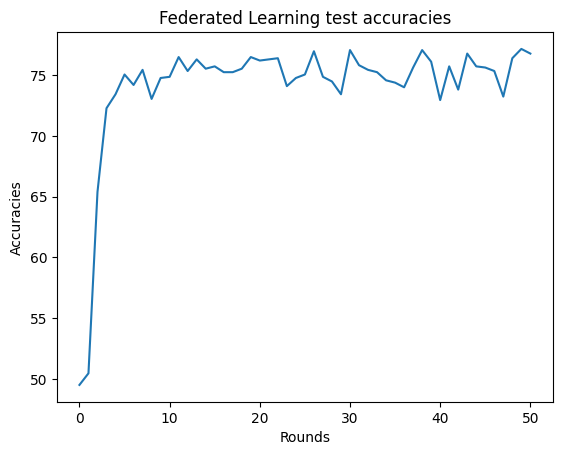

In [14]:
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [15]:
max(fl_acc)

tensor(77.1511, device='cuda:0')

## transfer learning

In [16]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config= {
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)
configuration_TL = dict(wandb.config)


/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


FL accuracy,▁▁▅▇▇▇█▇▇█████████▇▇▇█▇▇███▇▇████▇███▇██
FL loss,█▇▄▃▂▃▂▃▂▁▂▂▂▂▂▁▂▂▃▃▃▁▃▃▁▂▂▂▂▂▁▁▂▃▁▁▂▃▂▁
FL accuracy,76.76865
FL loss,0.02957



Epoch 1/100
Epoch 1: Training accuracy: 50.0 Testing accuracy: 49.159664154052734.

Epoch 2/100
Epoch 2: Training accuracy: 57.105262756347656 Testing accuracy: 54.20167922973633.

Epoch 3/100
Epoch 3: Training accuracy: 60.78947448730469 Testing accuracy: 57.35293960571289.

Epoch 4/100
Epoch 4: Training accuracy: 63.05263137817383 Testing accuracy: 58.40336227416992.

Epoch 5/100
Epoch 5: Training accuracy: 65.31578826904297 Testing accuracy: 59.66386413574219.

Epoch 6/100
Epoch 6: Training accuracy: 67.47368621826172 Testing accuracy: 61.764705657958984.

Epoch 7/100
Epoch 7: Training accuracy: 69.21052551269531 Testing accuracy: 61.554622650146484.

Epoch 8/100
Epoch 8: Training accuracy: 70.0 Testing accuracy: 63.025211334228516.

Epoch 9/100
Epoch 9: Training accuracy: 71.31578826904297 Testing accuracy: 63.025211334228516.

Epoch 10/100
Epoch 10: Training accuracy: 73.0526351928711 Testing accuracy: 65.75630187988281.

Epoch 11/100
Epoch 11: Training accuracy: 73.2631607055664

transfer training accuracy,▁▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇██▇▇█▇▇▇████▇███████▇███
transfer validationaccuracy,▁▄▅▅▆▇▇▇▇▇█████████████▇█▇██▇█▇█████▇██▇
transfer training accuracy,83.73684
transfer validationaccuracy,69.95798


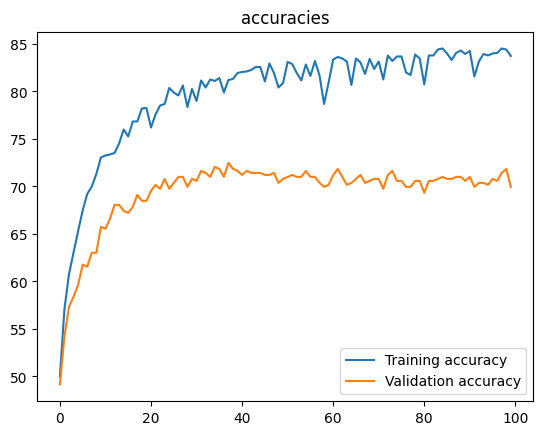

In [17]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration_TL, configuration_TL['epochs'], name= 'transfer')
    loss, accuracy = test(net, azure_test_loader, configuration_TL)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration_TL)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

## Federated Transfer Learning

In [18]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "federated transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config= configuration
)


In [19]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FTL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FTL, parameters_centralized)

In [20]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FTL, trainloader, valloader, configuration).to_client()


In [21]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
ftl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FTL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FTL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    ftl_acc.append(accuracy)
    metrics = {'FTL loss': loss,
               "FTL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FTL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-18 21:24:42,847	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'node:__internal_head__': 1.0, 'memory': 105385518080.0, 'node:192.168.1.146': 1.0, 'object_store_memory': 49450936320.0, 'accelerator_type:G': 1.0, 'GPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.04561318720088286 / accuracy 49.52198791503906
(ClientAppActor pid=1215791) 
(ClientAppActor pid=1215791) Epoch 1/100
(ClientAppActor pid=1215791) Epoch 1: Training accuracy: 47.39130401611328 Testing accuracy: 51.44508743286133.
(ClientAppActor pid=1215791) Epoch 2: Training accuracy: 52.60869598388672 Testing accuracy: 48.55491256713867.
(ClientAppActor pid=1215791) Epoch 3: Training accuracy: 52.60869598388672 Testing accuracy: 48.55491256713867.
(ClientAppActor pid=1215791) Epoch 4: Training accuracy: 52.60869598388672 Testing accuracy: 48.55491256713867.
(ClientAppActor pid=1215791) Epoch 5: Training accuracy: 52.60869598388672 Testing accuracy: 48.55491256713867.
(ClientAppActor pid=1215791) Epoch 6: Training accuracy: 52.60869598388672 Testing accuracy: 48.55491256713867.
(ClientAppActor pid=1215791) Epoch 7: Training accuracy: 52.60869598388672 Testing accuracy: 48.55491256713867.
(ClientAppActor pid=1215791) Epoch 8: Training accuracy: 52.60869598

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.039693537880392635, {'accuracy': tensor(56.4054, device='cuda:0')}, 42.702647509009694)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.039693537880392635 / accuracy 56.40535354614258
(ClientAppActor pid=1215792) Epoch 100: Training accuracy: 66.22613525390625 Testing accuracy: 63.74269104003906. [repeated 70x across cluster]
(ClientAppActor pid=1215791)  [repeated 132x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 132x across cluster]
(ClientAppActor pid=1215791) Epoch 5: Training accuracy: 68.13509368896484 Testing accuracy: 71.92982482910156. [repeated 133x across cluster]
(ClientAppActor pid=1215791)  [repeated 53x across cluster]
(ClientAppActor pid=1215791) Epoch 41/100 [repeated 53x across cluster]
(ClientAppActor pid=1215791) Epoch 45: Training accuracy: 74.30249786376953 Testing accuracy: 71.92982482910156. [repeated 58x across cluster]
(ClientAppActor pid=1215791)  [repeated 55x across cluster]
(ClientAppActor pid=1215791) Epoch 79/100 [repeated 55x across cluster]
(ClientAppActor pid=1215791) Epoch 99: Training accuracy: 77.09251403808594 Testing accuracy: 7

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.03520810604095459, {'accuracy': tensor(68.2600, device='cuda:0')}, 84.52067201099999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03520810604095459 / accuracy 68.26004028320312


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 19x across cluster]
(ClientAppActor pid=1215791) Epoch 8/100 [repeated 19x across cluster]
(ClientAppActor pid=1215791) Epoch 9: Training accuracy: 74.15565490722656 Testing accuracy: 72.51461791992188. [repeated 19x across cluster]
(ClientAppActor pid=1215791)  [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 23/100 [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 25: Training accuracy: 72.98091125488281 Testing accuracy: 71.92982482910156. [repeated 27x across cluster]
(ClientAppActor pid=1215791)  [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 44/100 [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 48: Training accuracy: 74.8898696899414 Testing accuracy: 71.92982482910156. [repeated 38x across cluster]
(ClientAppActor pid=1215791)  [repeated 39x across cluster]
(ClientAppActor pid=1215791) Epoch 66/100 [repeated 39x across cluster]
(ClientAppActor pid=1215791) Epoch 70: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.03430942577474257, {'accuracy': tensor(70.8413, device='cuda:0')}, 166.04794866300654)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03430942577474257 / accuracy 70.84130096435547
(ClientAppActor pid=1215791)  [repeated 271x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 271x across cluster]
(ClientAppActor pid=1215791) Epoch 3: Training accuracy: 75.07246398925781 Testing accuracy: 75.72254180908203. [repeated 273x across cluster]
(ClientAppActor pid=1215791)  [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 28/100 [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 31: Training accuracy: 71.3043441772461 Testing accuracy: 71.67630004882812. [repeated 42x across cluster]
(ClientAppActor pid=1215792)  [repeated 41x across cluster]
(ClientAppActor pid=1215792) Epoch 94/100 [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 57: Training accuracy: 79.27536010742188 Testing accuracy: 75.1445083618164. [repeated 39x across cluster]
(ClientAppActor pid=1215791)  [repeated 20x across cluster]
(ClientAppActor pid=1215791) Epoch 69/1

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.03423414861454683, {'accuracy': tensor(72.5621, device='cuda:0')}, 196.36619810700358)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03423414861454683 / accuracy 72.56214141845703


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791) Epoch 100: Training accuracy: 83.47826385498047 Testing accuracy: 74.56647491455078. [repeated 15x across cluster]
(ClientAppActor pid=1215792)  [repeated 20x across cluster]
(ClientAppActor pid=1215792) Epoch 10/100 [repeated 20x across cluster]
(ClientAppActor pid=1215791) Epoch 14: Training accuracy: 73.71512603759766 Testing accuracy: 73.68421173095703. [repeated 26x across cluster]
(ClientAppActor pid=1215791)  [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 27/100 [repeated 29x across cluster]
(ClientAppActor pid=1215792) Epoch 24: Training accuracy: 80.06279754638672 Testing accuracy: 76.875. [repeated 26x across cluster]
(ClientAppActor pid=1215792)  [repeated 28x across cluster]
(ClientAppActor pid=1215792) Epoch 35/100 [repeated 28x across cluster]
(ClientAppActor pid=1215791) Epoch 45: Training accuracy: 74.74302673339844 Testing accuracy: 72.51461791992188. [repeated 30x across cluster]
(ClientAppActor pid=1215792)  [repeated 26

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.03370464198729571, {'accuracy': tensor(73.7094, device='cuda:0')}, 265.8290397039964)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03370464198729571 / accuracy 73.70936584472656
(ClientAppActor pid=1215791)  [repeated 48x across cluster]
(ClientAppActor pid=1215791) Epoch 25/100 [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoch 18: Training accuracy: 75.77092742919922 Testing accuracy: 71.34503173828125. [repeated 58x across cluster]
(ClientAppActor pid=1215791)  [repeated 56x across cluster]
(ClientAppActor pid=1215791) Epoch 50/100 [repeated 56x across cluster]
(ClientAppActor pid=1215791) Epoch 53: Training accuracy: 78.17896270751953 Testing accuracy: 75.625. [repeated 48x across cluster]
(ClientAppActor pid=1215791)  [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 65/100 [repeated 26x across cluster]
(ClientAppActor pid=1215792) Epoch 54: Training accuracy: 79.58883666992188 Testing accuracy: 70.1754379272461. [repeated 27x across cluster]
(ClientAppActor pid=1215791)  [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 81/100 [repeate

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.03222810520845301, {'accuracy': tensor(74.2830, device='cuda:0')}, 337.910161066)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03222810520845301 / accuracy 74.2829818725586


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 17x across cluster]
(ClientAppActor pid=1215791) Epoch 9/100 [repeated 17x across cluster]
(ClientAppActor pid=1215791) Epoch 11: Training accuracy: 78.70777893066406 Testing accuracy: 74.85379791259766. [repeated 19x across cluster]
(ClientAppActor pid=1215791)  [repeated 36x across cluster]
(ClientAppActor pid=1215791) Epoch 36/100 [repeated 36x across cluster]
(ClientAppActor pid=1215791) Epoch 42: Training accuracy: 77.82672882080078 Testing accuracy: 74.26900482177734. [repeated 39x across cluster]
(ClientAppActor pid=1215791)  [repeated 43x across cluster]
(ClientAppActor pid=1215791) Epoch 70/100 [repeated 43x across cluster]
(ClientAppActor pid=1215791) Epoch 74: Training accuracy: 81.20410919189453 Testing accuracy: 74.85379791259766. [repeated 42x across cluster]
(ClientAppActor pid=1215791)  [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 3/100 [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 7: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.032539371181936824, {'accuracy': tensor(74.6654, device='cuda:0')}, 374.23463779099984)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032539371181936824 / accuracy 74.66539001464844
(ClientAppActor pid=1215792)  [repeated 239x across cluster]
(ClientAppActor pid=1215792) Epoch 68/100 [repeated 239x across cluster]
(ClientAppActor pid=1215791) Epoch 47: Training accuracy: 80.76358032226562 Testing accuracy: 76.02339172363281. [repeated 264x across cluster]
(ClientAppActor pid=1215791)  [repeated 65x across cluster]
(ClientAppActor pid=1215791) Epoch 67/100 [repeated 65x across cluster]
(ClientAppActor pid=1215791) Epoch 70: Training accuracy: 79.4419937133789 Testing accuracy: 76.02339172363281. [repeated 40x across cluster]
(ClientAppActor pid=1215792)  [repeated 41x across cluster]
(ClientAppActor pid=1215792) Epoch 24/100 [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 97: Training accuracy: 77.53304290771484 Testing accuracy: 74.85379791259766. [repeated 40x across cluster]
(ClientAppActor pid=1215791)  [repeated 37x across cluster]
(ClientAppActor pid=1215791) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.03301083340364344, {'accuracy': tensor(74.0918, device='cuda:0')}, 428.8419402639993)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03301083340364344 / accuracy 74.09178161621094


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 24x across cluster]
(ClientAppActor pid=1215791) Epoch 15/100 [repeated 24x across cluster]
(ClientAppActor pid=1215792) Epoch 9: Training accuracy: 78.33595275878906 Testing accuracy: 77.5. [repeated 26x across cluster]
(ClientAppActor pid=1215791)  [repeated 31x across cluster]
(ClientAppActor pid=1215791) Epoch 34/100 [repeated 31x across cluster]
(ClientAppActor pid=1215791) Epoch 35: Training accuracy: 80.02936553955078 Testing accuracy: 77.19298553466797. [repeated 30x across cluster]
(ClientAppActor pid=1215791)  [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 57/100 [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 58: Training accuracy: 81.64463806152344 Testing accuracy: 76.60818481445312. [repeated 35x across cluster]
(ClientAppActor pid=1215791)  [repeated 132x across cluster]
(ClientAppActor pid=1215791) Epoch 72/100 [repeated 132x across cluster]
(ClientAppActor pid=1215791) Epoch 87: Training accurac

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.033947264446931726, {'accuracy': tensor(72.6577, device='cuda:0')}, 458.22631038099644)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.033947264446931726 / accuracy 72.65774536132812


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 23x across cluster]
(ClientAppActor pid=1215792) Epoch 100: Training accuracy: 81.00470733642578 Testing accuracy: 76.25. [repeated 21x across cluster]
(ClientAppActor pid=1215791)  [repeated 55x across cluster]
(ClientAppActor pid=1215791) Epoch 34/100 [repeated 55x across cluster]
(ClientAppActor pid=1215791) Epoch 33: Training accuracy: 84.12322235107422 Testing accuracy: 73.58490753173828. [repeated 54x across cluster]
(ClientAppActor pid=1215791)  [repeated 50x across cluster]
(ClientAppActor pid=1215791) Epoch 61/100 [repeated 50x across cluster]
(ClientAppActor pid=1215791) Epoch 60: Training accuracy: 84.24170684814453 Testing accuracy: 72.16981506347656. [repeated 50x across cluster]
(ClientAppActor pid=1215792)  [repeated 55x across cluster]
(ClientAppActor pid=1215792) Epoch 77/100 [repeated 55x across cluster]
(ClientAppActor pid=1215792) Epoch 76: Training accurac

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.034958818379570454, {'accuracy': tensor(71.3193, device='cuda:0')}, 520.2201611100027)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=1215792)  [repeated 18x across cluster]
(ClientAppActor pid=1215792) Epoch 100/100 [repeated 18x across cluster]
(ClientAppActor pid=1215792) Epoch 100: Training accuracy: 84.77236938476562 Testing accuracy: 77.5. [repeated 19x across cluster]
Server-side evaluation loss 0.034958818379570454 / accuracy 71.3193130493164


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 47x across cluster]
(ClientAppActor pid=1215791) Epoch 32/100 [repeated 47x across cluster]
(ClientAppActor pid=1215791) Epoch 31: Training accuracy: 82.10900115966797 Testing accuracy: 71.69811248779297. [repeated 45x across cluster]
(ClientAppActor pid=1215791)  [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 50/100 [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 49: Training accuracy: 83.29383850097656 Testing accuracy: 75.0. [repeated 29x across cluster]
(ClientAppActor pid=1215791)  [repeated 30x across cluster]
(ClientAppActor pid=1215791) Epoch 67/100 [repeated 30x across cluster]
(ClientAppActor pid=1215791) Epoch 66: Training accuracy: 84.47867584228516 Testing accuracy: 70.28302001953125. [repeated 30x across cluster]
(ClientAppActor pid=1215791)  [repeated 28x across cluster]
(ClientAppActor pid=1215791) Epoch 84/100 [repeated 28x across cluster]
(ClientAppActor pid=1215791) Epoch 83: Training accuracy

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.03391737797681023, {'accuracy': tensor(73.7094, device='cuda:0')}, 568.9852894570067)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03391737797681023 / accuracy 73.70936584472656


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 93x across cluster]
(ClientAppActor pid=1215791) Epoch 66/100 [repeated 93x across cluster]
(ClientAppActor pid=1215791) Epoch 65: Training accuracy: 84.95260620117188 Testing accuracy: 73.11320495605469. [repeated 92x across cluster]
(ClientAppActor pid=1215791)  [repeated 238x across cluster]
(ClientAppActor pid=1215791) Epoch 84/100 [repeated 238x across cluster]
(ClientAppActor pid=1215791) Epoch 83: Training accuracy: 71.6593246459961 Testing accuracy: 70.1754379272461. [repeated 238x across cluster]
(ClientAppActor pid=1215792)  [repeated 55x across cluster]
(ClientAppActor pid=1215792) Epoch 63/100 [repeated 55x across cluster]
(ClientAppActor pid=1215792) Epoch 62: Training accuracy: 72.89855194091797 Testing accuracy: 69.94219970703125. [repeated 56x across cluster]
(ClientAppActor pid=1215792)  [repeated 18x across cluster]
(ClientAppActor pid=1215792) Epoch 81/100 [repeated 18x across cluster]
(ClientAppActor pid=1215792) Epoch 80: Tra

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.0341080532354467, {'accuracy': tensor(74.2830, device='cuda:0')}, 591.3511005089968)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.0341080532354467 / accuracy 74.2829818725586


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 20x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 20x across cluster]
(ClientAppActor pid=1215792) Epoch 100: Training accuracy: 86.81159210205078 Testing accuracy: 74.56647491455078. [repeated 20x across cluster]
(ClientAppActor pid=1215791)  [repeated 57x across cluster]
(ClientAppActor pid=1215791) Epoch 41/100 [repeated 57x across cluster]
(ClientAppActor pid=1215791) Epoch 40: Training accuracy: 85.79710388183594 Testing accuracy: 77.45664978027344. [repeated 56x across cluster]
(ClientAppActor pid=1215791)  [repeated 53x across cluster]
(ClientAppActor pid=1215791) Epoch 77/100 [repeated 53x across cluster]
(ClientAppActor pid=1215791) Epoch 76: Training accuracy: 85.79710388183594 Testing accuracy: 75.1445083618164. [repeated 53x across cluster]
(ClientAppActor pid=1215792)  [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoch 50/100 [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoch 49: Train

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.03445644238415886, {'accuracy': tensor(73.9962, device='cuda:0')}, 619.2137510290049)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03445644238415886 / accuracy 73.99617767333984


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 72x across cluster]
(ClientAppActor pid=1215791) Epoch 11/100 [repeated 72x across cluster]
(ClientAppActor pid=1215791) Epoch 10: Training accuracy: 80.9104232788086 Testing accuracy: 73.09941864013672. [repeated 72x across cluster]
(ClientAppActor pid=1215791)  [repeated 44x across cluster]
(ClientAppActor pid=1215791) Epoch 37/100 [repeated 44x across cluster]
(ClientAppActor pid=1215791) Epoch 36: Training accuracy: 81.64463806152344 Testing accuracy: 76.60818481445312. [repeated 44x across cluster]
(ClientAppActor pid=1215791)  [repeated 47x across cluster]
(ClientAppActor pid=1215791) Epoch 67/100 [repeated 47x across cluster]
(ClientAppActor pid=1215791) Epoch 66: Training accuracy: 83.84728240966797 Testing accuracy: 74.26900482177734. [repeated 47x across cluster]
(ClientAppActor pid=1215791)  [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 82/100 [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 81: Train

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.034759381238152, {'accuracy': tensor(72.5621, device='cuda:0')}, 698.7685244870081)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.034759381238152 / accuracy 72.56214141845703


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 49x across cluster]
(ClientAppActor pid=1215791) Epoch 38/100 [repeated 49x across cluster]
(ClientAppActor pid=1215791) Epoch 37: Training accuracy: 85.36231994628906 Testing accuracy: 74.56647491455078. [repeated 48x across cluster]
(ClientAppActor pid=1215791)  [repeated 233x across cluster]
(ClientAppActor pid=1215791) Epoch 35/100 [repeated 233x across cluster]
(ClientAppActor pid=1215791) Epoch 34: Training accuracy: 84.3014144897461 Testing accuracy: 78.75. [repeated 233x across cluster]
(ClientAppActor pid=1215792)  [repeated 118x across cluster]
(ClientAppActor pid=1215792) Epoch 91/100 [repeated 118x across cluster]
(ClientAppActor pid=1215792) Epoch 90: Training accuracy: 84.43465423583984 Testing accuracy: 73.68421173095703. [repeated 119x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.033119808225070727, {'accuracy': tensor(74.6654, device='cuda:0')}, 713.6637654020014)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.033119808225070727 / accuracy 74.66539001464844


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215792)  [repeated 25x across cluster]
(ClientAppActor pid=1215792) Epoch 10/100 [repeated 25x across cluster]
(ClientAppActor pid=1215792) Epoch 9: Training accuracy: 82.3459701538086 Testing accuracy: 75.94339752197266. [repeated 24x across cluster]
(ClientAppActor pid=1215791)  [repeated 49x across cluster]
(ClientAppActor pid=1215791) Epoch 42/100 [repeated 49x across cluster]
(ClientAppActor pid=1215791) Epoch 41: Training accuracy: 75.18355560302734 Testing accuracy: 68.42105102539062. [repeated 49x across cluster]
(ClientAppActor pid=1215791)  [repeated 57x across cluster]
(ClientAppActor pid=1215791) Epoch 82/100 [repeated 57x across cluster]
(ClientAppActor pid=1215791) Epoch 81: Training accuracy: 83.700439453125 Testing accuracy: 75.4385986328125. [repeated 57x across cluster]
(ClientAppActor pid=1215791)  [repeated 51x across cluster]
(ClientAppActor pid=1215791) Epoch 16/100 [repeated 51x across cluster]
(ClientAppActor pid=1215791) Epoch 15: Training 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.03367615797940422, {'accuracy': tensor(73.9006, device='cuda:0')}, 745.7568334149983)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03367615797940422 / accuracy 73.90057373046875
(ClientAppActor pid=1215791)  [repeated 325x across cluster]
(ClientAppActor pid=1215791) Epoch 42/100 [repeated 325x across cluster]
(ClientAppActor pid=1215791) Epoch 41: Training accuracy: 86.25592041015625 Testing accuracy: 74.52830505371094. [repeated 324x across cluster]
(ClientAppActor pid=1215791)  [repeated 43x across cluster]
(ClientAppActor pid=1215791) Epoch 62/100 [repeated 43x across cluster]
(ClientAppActor pid=1215791) Epoch 61: Training accuracy: 85.4265365600586 Testing accuracy: 74.52830505371094. [repeated 44x across cluster]
(ClientAppActor pid=1215791)  [repeated 11x across cluster]
(ClientAppActor pid=1215791) Epoch 73/100 [repeated 11x across cluster]
(ClientAppActor pid=1215791) Epoch 72: Training accuracy: 86.96682739257812 Testing accuracy: 74.52830505371094. [repeated 11x across cluster]
(ClientAppActor pid=1215791)  [repeated 12x across cluster]
(ClientAppActor pid=1215791) Epoch 8

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.03439816306619083, {'accuracy': tensor(73.7094, device='cuda:0')}, 772.9867450949969)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03439816306619083 / accuracy 73.70936584472656


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 15x across cluster]
(ClientAppActor pid=1215791) Epoch 8/100 [repeated 15x across cluster]
(ClientAppActor pid=1215791) Epoch 7: Training accuracy: 81.78964233398438 Testing accuracy: 75.625. [repeated 14x across cluster]
(ClientAppActor pid=1215791)  [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 26/100 [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 25: Training accuracy: 80.21977996826172 Testing accuracy: 74.375. [repeated 26x across cluster]
(ClientAppActor pid=1215791)  [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 42/100 [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 41: Training accuracy: 82.2605972290039 Testing accuracy: 75.625. [repeated 27x across cluster]
(ClientAppActor pid=1215791)  [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 57/100 [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 56: Training accuracy: 85.40031433105469 Tes

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.033426779157975144, {'accuracy': tensor(74.0918, device='cuda:0')}, 824.5488113949978)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033426779157975144 / accuracy 74.09178161621094
(ClientAppActor pid=1215792)  [repeated 143x across cluster]
(ClientAppActor pid=1215792) Epoch 51/100 [repeated 143x across cluster]
(ClientAppActor pid=1215792) Epoch 50: Training accuracy: 87.82608795166016 Testing accuracy: 74.56647491455078. [repeated 142x across cluster]
(ClientAppActor pid=1215792)  [repeated 22x across cluster]
(ClientAppActor pid=1215792) Epoch 62/100 [repeated 22x across cluster]
(ClientAppActor pid=1215792) Epoch 61: Training accuracy: 87.10144805908203 Testing accuracy: 72.25433349609375. [repeated 22x across cluster]
(ClientAppActor pid=1215791)  [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 65/100 [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 64: Training accuracy: 84.47867584228516 Testing accuracy: 69.3396224975586. [repeated 25x across cluster]
(ClientAppActor pid=1215791)  [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.03358770118040197, {'accuracy': tensor(73.5182, device='cuda:0')}, 893.0582553230051)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03358770118040197 / accuracy 73.5181655883789


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 16x across cluster]
(ClientAppActor pid=1215791) Epoch 7/100 [repeated 16x across cluster]
(ClientAppActor pid=1215791) Epoch 6: Training accuracy: 82.08516693115234 Testing accuracy: 76.02339172363281. [repeated 15x across cluster]
(ClientAppActor pid=1215792)  [repeated 42x across cluster]
(ClientAppActor pid=1215792) Epoch 22/100 [repeated 42x across cluster]
(ClientAppActor pid=1215792) Epoch 21: Training accuracy: 86.66666412353516 Testing accuracy: 71.67630004882812. [repeated 42x across cluster]
(ClientAppActor pid=1215791)  [repeated 75x across cluster]
(ClientAppActor pid=1215791) Epoch 55/100 [repeated 75x across cluster]
(ClientAppActor pid=1215791) Epoch 54: Training accuracy: 85.02202606201172 Testing accuracy: 75.4385986328125. [repeated 75x across cluster]
(ClientAppActor pid=1215791)  [repeated 73x across cluster]
(ClientAppActor pid=1215791) Epoch 92/100 [repeated 73x across cluster]
(ClientAppActor pid=1215791) Epoch 91: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.033403589445001935, {'accuracy': tensor(73.5182, device='cuda:0')}, 932.3643001210003)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.033403589445001935 / accuracy 73.5181655883789


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 17x across cluster]
(ClientAppActor pid=1215791) Epoch 7/100 [repeated 17x across cluster]
(ClientAppActor pid=1215791) Epoch 6: Training accuracy: 80.84772491455078 Testing accuracy: 76.25. [repeated 17x across cluster]
(ClientAppActor pid=1215791)  [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 24/100 [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 23: Training accuracy: 83.3594970703125 Testing accuracy: 76.25. [repeated 29x across cluster]
(ClientAppActor pid=1215791)  [repeated 28x across cluster]
(ClientAppActor pid=1215791) Epoch 41/100 [repeated 28x across cluster]
(ClientAppActor pid=1215791) Epoch 40: Training accuracy: 77.23704528808594 Testing accuracy: 73.75. [repeated 28x across cluster]
(ClientAppActor pid=1215792)  [repeated 26x across cluster]
(ClientAppActor pid=1215792) Epoch 39/100 [repeated 26x across cluster]
(ClientAppActor pid=1215792) Epoch 38: Training accuracy: 86.66666412353516 Testin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.032855686019448674, {'accuracy': tensor(74.6654, device='cuda:0')}, 1006.4658749350056)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032855686019448674 / accuracy 74.66539001464844


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 16x across cluster]
(ClientAppActor pid=1215791) Epoch 7/100 [repeated 16x across cluster]
(ClientAppActor pid=1215791) Epoch 6: Training accuracy: 84.24170684814453 Testing accuracy: 74.05660247802734. [repeated 15x across cluster]
(ClientAppActor pid=1215792)  [repeated 46x across cluster]
(ClientAppActor pid=1215792) Epoch 20/100 [repeated 46x across cluster]
(ClientAppActor pid=1215792) Epoch 19: Training accuracy: 86.02825927734375 Testing accuracy: 79.375. [repeated 46x across cluster]
(ClientAppActor pid=1215792)  [repeated 47x across cluster]
(ClientAppActor pid=1215792) Epoch 40/100 [repeated 47x across cluster]
(ClientAppActor pid=1215792) Epoch 39: Training accuracy: 86.81318664550781 Testing accuracy: 78.75. [repeated 47x across cluster]
(ClientAppActor pid=1215792)  [repeated 269x across cluster]
(ClientAppActor pid=1215792) Epoch 71/100 [repeated 269x across cluster]
(ClientAppActor pid=1215792) Epoch 70: Training accuracy: 85.46255

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.033980180235470045, {'accuracy': tensor(72.6577, device='cuda:0')}, 1030.4904060990084)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.033980180235470045 / accuracy 72.65774536132812


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 12/100 [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 11: Training accuracy: 86.7298583984375 Testing accuracy: 73.58490753173828. [repeated 26x across cluster]
(ClientAppActor pid=1215792)  [repeated 33x across cluster]
(ClientAppActor pid=1215792) Epoch 25/100 [repeated 33x across cluster]
(ClientAppActor pid=1215792) Epoch 24: Training accuracy: 86.18524169921875 Testing accuracy: 78.125. [repeated 33x across cluster]
(ClientAppActor pid=1215791)  [repeated 21x across cluster]
(ClientAppActor pid=1215791) Epoch 40/100 [repeated 21x across cluster]
(ClientAppActor pid=1215791) Epoch 39: Training accuracy: 86.37440490722656 Testing accuracy: 73.58490753173828. [repeated 21x across cluster]
(ClientAppActor pid=1215791)  [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 53/100 [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 52: Training accurac

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.03114180705126594, {'accuracy': tensor(76.0038, device='cuda:0')}, 1100.4788437670068)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03114180705126594 / accuracy 76.00382232666016
(ClientAppActor pid=1215791)  [repeated 32x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 32x across cluster]
(ClientAppActor pid=1215791) Epoch 100: Training accuracy: 85.31571197509766 Testing accuracy: 74.26900482177734. [repeated 33x across cluster]
(ClientAppActor pid=1215791)  [repeated 163x across cluster]
(ClientAppActor pid=1215791) Epoch 53/100 [repeated 163x across cluster]
(ClientAppActor pid=1215791) Epoch 52: Training accuracy: 87.5362319946289 Testing accuracy: 74.56647491455078. [repeated 162x across cluster]
(ClientAppActor pid=1215792)  [repeated 114x across cluster]
(ClientAppActor pid=1215792) Epoch 94/100 [repeated 114x across cluster]
(ClientAppActor pid=1215792) Epoch 93: Training accuracy: 86.25592041015625 Testing accuracy: 73.11320495605469. [repeated 114x across cluster]
(ClientAppActor pid=1215792)  [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoc

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.033137198756722844, {'accuracy': tensor(73.0402, device='cuda:0')}, 1127.6704862930055)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.033137198756722844 / accuracy 73.04015350341797


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215792)  [repeated 43x across cluster]
(ClientAppActor pid=1215792) Epoch 24/100 [repeated 43x across cluster]
(ClientAppActor pid=1215792) Epoch 23: Training accuracy: 87.82608795166016 Testing accuracy: 75.72254180908203. [repeated 42x across cluster]
(ClientAppActor pid=1215792)  [repeated 55x across cluster]
(ClientAppActor pid=1215792) Epoch 55/100 [repeated 55x across cluster]
(ClientAppActor pid=1215792) Epoch 54: Training accuracy: 87.10144805908203 Testing accuracy: 74.56647491455078. [repeated 55x across cluster]
(ClientAppActor pid=1215792)  [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoch 83/100 [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoch 82: Training accuracy: 83.76811218261719 Testing accuracy: 71.67630004882812. [repeated 48x across cluster]
(ClientAppActor pid=1215791)  [repeated 30x across cluster]
(ClientAppActor pid=1215791) Epoch 72/100 [repeated 30x across cluster]
(ClientAppActor pid=1215791) Epoch 71: Trai

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.03347342855790082, {'accuracy': tensor(72.6577, device='cuda:0')}, 1183.6067162079999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03347342855790082 / accuracy 72.65774536132812


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 27/100 [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 26: Training accuracy: 88.1159439086914 Testing accuracy: 75.1445083618164. [repeated 34x across cluster]
(ClientAppActor pid=1215791)  [repeated 52x across cluster]
(ClientAppActor pid=1215791) Epoch 66/100 [repeated 52x across cluster]
(ClientAppActor pid=1215791) Epoch 65: Training accuracy: 83.33333587646484 Testing accuracy: 69.3641586303711. [repeated 52x across cluster]
(ClientAppActor pid=1215791)  [repeated 57x across cluster]
(ClientAppActor pid=1215791) Epoch 12/100 [repeated 57x across cluster]
(ClientAppActor pid=1215791) Epoch 11: Training accuracy: 83.84728240966797 Testing accuracy: 74.85379791259766. [repeated 57x across cluster]
(ClientAppActor pid=1215791)  [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 42/100 [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 41: Trainin

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.032760862041922176, {'accuracy': tensor(74.9522, device='cuda:0')}, 1218.1016927710007)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032760862041922176 / accuracy 74.95220184326172
(ClientAppActor pid=1215791)  [repeated 146x across cluster]
(ClientAppActor pid=1215791) Epoch 29/100 [repeated 146x across cluster]
(ClientAppActor pid=1215791) Epoch 28: Training accuracy: 87.5362319946289 Testing accuracy: 73.98844146728516. [repeated 145x across cluster]
(ClientAppActor pid=1215791)  [repeated 48x across cluster]
(ClientAppActor pid=1215791) Epoch 68/100 [repeated 48x across cluster]
(ClientAppActor pid=1215791) Epoch 67: Training accuracy: 88.26087188720703 Testing accuracy: 73.98844146728516. [repeated 48x across cluster]
(ClientAppActor pid=1215791)  [repeated 53x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 53x across cluster]
(ClientAppActor pid=1215792) Epoch 44: Training accuracy: 87.20378875732422 Testing accuracy: 74.52830505371094. [repeated 53x across cluster]
(ClientAppActor pid=1215792)  [repeated 40x across cluster]
(ClientAppActor pid=1215792) Epoch 6

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.03252387397429522, {'accuracy': tensor(74.6654, device='cuda:0')}, 1266.3218621590058)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03252387397429522 / accuracy 74.66539001464844


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 16x across cluster]
(ClientAppActor pid=1215791) Epoch 6/100 [repeated 16x across cluster]
(ClientAppActor pid=1215791) Epoch 5: Training accuracy: 82.73155212402344 Testing accuracy: 76.25. [repeated 15x across cluster]
(ClientAppActor pid=1215791)  [repeated 31x across cluster]
(ClientAppActor pid=1215791) Epoch 23/100 [repeated 31x across cluster]
(ClientAppActor pid=1215791) Epoch 22: Training accuracy: 86.65620422363281 Testing accuracy: 79.375. [repeated 31x across cluster]
(ClientAppActor pid=1215791)  [repeated 42x across cluster]
(ClientAppActor pid=1215791) Epoch 48/100 [repeated 42x across cluster]
(ClientAppActor pid=1215791) Epoch 47: Training accuracy: 86.02825927734375 Testing accuracy: 76.25. [repeated 42x across cluster]
(ClientAppActor pid=1215791)  [repeated 51x across cluster]
(ClientAppActor pid=1215791) Epoch 73/100 [repeated 51x across cluster]
(ClientAppActor pid=1215791) Epoch 72: Training accuracy: 82.4175796508789 Testi

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.03277634522494148, {'accuracy': tensor(73.7094, device='cuda:0')}, 1333.095901755005)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03277634522494148 / accuracy 73.70936584472656


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 8/100 [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 7: Training accuracy: 86.52173614501953 Testing accuracy: 76.30057525634766. [repeated 22x across cluster]
(ClientAppActor pid=1215791)  [repeated 61x across cluster]
(ClientAppActor pid=1215791) Epoch 38/100 [repeated 61x across cluster]
(ClientAppActor pid=1215791) Epoch 37: Training accuracy: 88.26087188720703 Testing accuracy: 72.83236694335938. [repeated 61x across cluster]
(ClientAppActor pid=1215791)  [repeated 273x across cluster]
(ClientAppActor pid=1215791) Epoch 91/100 [repeated 273x across cluster]
(ClientAppActor pid=1215791) Epoch 90: Training accuracy: 87.44075775146484 Testing accuracy: 74.05660247802734. [repeated 273x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.03192980149213005, {'accuracy': tensor(74.5698, device='cuda:0')}, 1346.8293976340065)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03192980149213005 / accuracy 74.56978607177734
(ClientAppActor pid=1215791)  [repeated 153x across cluster]
(ClientAppActor pid=1215791) Epoch 35/100 [repeated 153x across cluster]
(ClientAppActor pid=1215791) Epoch 34: Training accuracy: 87.44075775146484 Testing accuracy: 74.05660247802734. [repeated 153x across cluster]
(ClientAppActor pid=1215791)  [repeated 22x across cluster]
(ClientAppActor pid=1215791) Epoch 46/100 [repeated 22x across cluster]
(ClientAppActor pid=1215791) Epoch 45: Training accuracy: 86.37440490722656 Testing accuracy: 72.64151000976562. [repeated 22x across cluster]
(ClientAppActor pid=1215791)  [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 59/100 [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 58: Training accuracy: 86.84834289550781 Testing accuracy: 72.16981506347656. [repeated 27x across cluster]
(ClientAppActor pid=1215792)  [repeated 23x across cluster]
(ClientAppActor pid=1215792) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.031946841408224666, {'accuracy': tensor(74.3786, device='cuda:0')}, 1412.1565802499972)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.031946841408224666 / accuracy 74.37858581542969


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 8/100 [repeated 35x across cluster]
(ClientAppActor pid=1215791) Epoch 7: Training accuracy: 87.5362319946289 Testing accuracy: 76.87861633300781. [repeated 35x across cluster]
(ClientAppActor pid=1215791)  [repeated 187x across cluster]
(ClientAppActor pid=1215791) Epoch 81/100 [repeated 187x across cluster]
(ClientAppActor pid=1215791) Epoch 80: Training accuracy: 87.79621124267578 Testing accuracy: 72.16981506347656. [repeated 187x across cluster]
(ClientAppActor pid=1215792)  [repeated 139x across cluster]
(ClientAppActor pid=1215792) Epoch 35/100 [repeated 139x across cluster]
(ClientAppActor pid=1215792) Epoch 34: Training accuracy: 85.24333190917969 Testing accuracy: 78.75. [repeated 140x across cluster]
(ClientAppActor pid=1215792)  [repeated 18x across cluster]
(ClientAppActor pid=1215792) Epoch 53/100 [repeated 18x across cluster]
(ClientAppActor pid=1215792) Epoch 52: Training accu

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.03203623785692103, {'accuracy': tensor(74.8566, device='cuda:0')}, 1449.6373240520043)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=1215792)  [repeated 12x across cluster]
(ClientAppActor pid=1215792) Epoch 100/100 [repeated 12x across cluster]
(ClientAppActor pid=1215792) Epoch 100: Training accuracy: 85.40031433105469 Testing accuracy: 76.25. [repeated 13x across cluster]
Server-side evaluation loss 0.03203623785692103 / accuracy 74.85659790039062


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 34/100 [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 33: Training accuracy: 76.94567108154297 Testing accuracy: 70.1754379272461. [repeated 39x across cluster]
(ClientAppActor pid=1215791)  [repeated 47x across cluster]
(ClientAppActor pid=1215791) Epoch 71/100 [repeated 47x across cluster]
(ClientAppActor pid=1215791) Epoch 70: Training accuracy: 86.4904556274414 Testing accuracy: 73.68421173095703. [repeated 47x across cluster]
(ClientAppActor pid=1215791)  [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 3/100 [repeated 41x across cluster]
(ClientAppActor pid=1215791) Epoch 2: Training accuracy: 81.3043441772461 Testing accuracy: 74.56647491455078. [repeated 41x across cluster]
(ClientAppActor pid=1215791)  [repeated 119x across cluster]
(ClientAppActor pid=1215791) Epoch 9/100 [repeated 119x across cluster]
(ClientAppActor pid=1215791) Epoch 8: Training 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.03262832234887516, {'accuracy': tensor(73.7094, device='cuda:0')}, 1477.4545442030067)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03262832234887516 / accuracy 73.70936584472656
(ClientAppActor pid=1215792)  [repeated 113x across cluster]
(ClientAppActor pid=1215792) Epoch 30/100 [repeated 113x across cluster]
(ClientAppActor pid=1215792) Epoch 29: Training accuracy: 87.12715911865234 Testing accuracy: 77.5. [repeated 112x across cluster]
(ClientAppActor pid=1215792)  [repeated 35x across cluster]
(ClientAppActor pid=1215792) Epoch 49/100 [repeated 35x across cluster]
(ClientAppActor pid=1215792) Epoch 48: Training accuracy: 87.12715911865234 Testing accuracy: 76.875. [repeated 35x across cluster]
(ClientAppActor pid=1215792)  [repeated 23x across cluster]
(ClientAppActor pid=1215792) Epoch 62/100 [repeated 23x across cluster]
(ClientAppActor pid=1215792) Epoch 61: Training accuracy: 86.18524169921875 Testing accuracy: 77.5. [repeated 23x across cluster]
(ClientAppActor pid=1215792)  [repeated 24x across cluster]
(ClientAppActor pid=1215792) Epoch 73/100 [repeated 24x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.03145020498948939, {'accuracy': tensor(74.7610, device='cuda:0')}, 1549.971215491998)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03145020498948939 / accuracy 74.76099395751953


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 33x across cluster]
(ClientAppActor pid=1215791) Epoch 19/100 [repeated 33x across cluster]
(ClientAppActor pid=1215791) Epoch 18: Training accuracy: 84.58149719238281 Testing accuracy: 75.4385986328125. [repeated 32x across cluster]
(ClientAppActor pid=1215791)  [repeated 98x across cluster]
(ClientAppActor pid=1215791) Epoch 3/100 [repeated 98x across cluster]
(ClientAppActor pid=1215791) Epoch 2: Training accuracy: 85.07246398925781 Testing accuracy: 76.30057525634766. [repeated 98x across cluster]
(ClientAppActor pid=1215791)  [repeated 44x across cluster]
(ClientAppActor pid=1215791) Epoch 39/100 [repeated 44x across cluster]
(ClientAppActor pid=1215791) Epoch 38: Training accuracy: 88.6956558227539 Testing accuracy: 75.1445083618164. [repeated 44x across cluster]
(ClientAppActor pid=1215791)  [repeated 40x across cluster]
(ClientAppActor pid=1215791) Epoch 71/100 [repeated 40x across cluster]
(ClientAppActor pid=1215791) Epoch 70: Training 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.03333754399243523, {'accuracy': tensor(73.9006, device='cuda:0')}, 1596.8646118080069)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03333754399243523 / accuracy 73.90057373046875
(ClientAppActor pid=1215791)  [repeated 71x across cluster]
(ClientAppActor pid=1215791) Epoch 43/100 [repeated 71x across cluster]
(ClientAppActor pid=1215791) Epoch 42: Training accuracy: 87.28414154052734 Testing accuracy: 76.875. [repeated 70x across cluster]
(ClientAppActor pid=1215791)  [repeated 307x across cluster]
(ClientAppActor pid=1215791) Epoch 61/100 [repeated 307x across cluster]
(ClientAppActor pid=1215791) Epoch 60: Training accuracy: 85.6093978881836 Testing accuracy: 73.09941864013672. [repeated 308x across cluster]
(ClientAppActor pid=1215791)  [repeated 28x across cluster]
(ClientAppActor pid=1215791) Epoch 89/100 [repeated 28x across cluster]
(ClientAppActor pid=1215791) Epoch 88: Training accuracy: 86.0499267578125 Testing accuracy: 72.51461791992188. [repeated 28x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.03107204507378971, {'accuracy': tensor(75.1434, device='cuda:0')}, 1612.993723150008)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03107204507378971 / accuracy 75.14340209960938


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 12x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 12x across cluster]
(ClientAppActor pid=1215791) Epoch 100: Training accuracy: 86.34361267089844 Testing accuracy: 71.92982482910156. [repeated 12x across cluster]
(ClientAppActor pid=1215791)  [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 17/100 [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 16: Training accuracy: 88.40579986572266 Testing accuracy: 73.98844146728516. [repeated 28x across cluster]
(ClientAppActor pid=1215791)  [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 32/100 [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 31: Training accuracy: 88.26087188720703 Testing accuracy: 74.56647491455078. [repeated 25x across cluster]
(ClientAppActor pid=1215791)  [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 46/100 [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 45: Trai

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 0.03194190824733061, {'accuracy': tensor(74.2830, device='cuda:0')}, 1684.6065783390077)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03194190824733061 / accuracy 74.2829818725586
(ClientAppActor pid=1215791)  [repeated 19x across cluster]
(ClientAppActor pid=1215791) Epoch 3/100 [repeated 19x across cluster]
(ClientAppActor pid=1215791) Epoch 2: Training accuracy: 84.1409683227539 Testing accuracy: 76.02339172363281. [repeated 18x across cluster]
(ClientAppActor pid=1215792)  [repeated 57x across cluster]
(ClientAppActor pid=1215792) Epoch 14/100 [repeated 57x across cluster]
(ClientAppActor pid=1215792) Epoch 13: Training accuracy: 87.97101593017578 Testing accuracy: 72.25433349609375. [repeated 57x across cluster]
(ClientAppActor pid=1215791)  [repeated 53x across cluster]
(ClientAppActor pid=1215791) Epoch 85/100 [repeated 53x across cluster]
(ClientAppActor pid=1215791) Epoch 84: Training accuracy: 84.1409683227539 Testing accuracy: 73.68421173095703. [repeated 53x across cluster]
(ClientAppActor pid=1215791)  [repeated 69x across cluster]
(ClientAppActor pid=1215791) Epoch 37/100 [

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.03190425213645486, {'accuracy': tensor(74.5698, device='cuda:0')}, 1734.9504833050014)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03190425213645486 / accuracy 74.56978607177734


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 22x across cluster]
(ClientAppActor pid=1215791) Epoch 5/100 [repeated 22x across cluster]
(ClientAppActor pid=1215791) Epoch 4: Training accuracy: 86.9565200805664 Testing accuracy: 76.87861633300781. [repeated 21x across cluster]
(ClientAppActor pid=1215791)  [repeated 45x across cluster]
(ClientAppActor pid=1215791) Epoch 33/100 [repeated 45x across cluster]
(ClientAppActor pid=1215791) Epoch 32: Training accuracy: 87.68115997314453 Testing accuracy: 75.1445083618164. [repeated 45x across cluster]
(ClientAppActor pid=1215791)  [repeated 24x across cluster]
(ClientAppActor pid=1215791) Epoch 46/100 [repeated 24x across cluster]
(ClientAppActor pid=1215791) Epoch 45: Training accuracy: 86.66666412353516 Testing accuracy: 69.94219970703125. [repeated 24x across cluster]
(ClientAppActor pid=1215792)  [repeated 28x across cluster]
(ClientAppActor pid=1215792) Epoch 43/100 [repeated 28x across cluster]
(ClientAppActor pid=1215792) Epoch 42: Training

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.032058491426355695, {'accuracy': tensor(74.1874, device='cuda:0')}, 1827.3531828209962)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032058491426355695 / accuracy 74.1873779296875


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 12/100 [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 11: Training accuracy: 83.83045196533203 Testing accuracy: 75.625. [repeated 25x across cluster]
(ClientAppActor pid=1215791)  [repeated 80x across cluster]
(ClientAppActor pid=1215791) Epoch 64/100 [repeated 80x across cluster]
(ClientAppActor pid=1215791) Epoch 63: Training accuracy: 86.65620422363281 Testing accuracy: 77.5. [repeated 80x across cluster]
(ClientAppActor pid=1215791)  [repeated 38x across cluster]
(ClientAppActor pid=1215791) Epoch 84/100 [repeated 38x across cluster]
(ClientAppActor pid=1215791) Epoch 83: Training accuracy: 86.81318664550781 Testing accuracy: 77.5. [repeated 38x across cluster]
(ClientAppActor pid=1215791)  [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 25x across cluster]
(ClientAppActor pid=1215792) Epoch 58: Training accuracy: 87.79621124267578 Testi

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.032583261237424964, {'accuracy': tensor(74.0918, device='cuda:0')}, 1903.695471169005)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032583261237424964 / accuracy 74.09178161621094


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215792)  [repeated 17x across cluster]
(ClientAppActor pid=1215792) Epoch 7/100 [repeated 17x across cluster]
(ClientAppActor pid=1215792) Epoch 6: Training accuracy: 86.0499267578125 Testing accuracy: 74.85379791259766. [repeated 16x across cluster]
(ClientAppActor pid=1215791)  [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 21/100 [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 20: Training accuracy: 87.79621124267578 Testing accuracy: 73.58490753173828. [repeated 23x across cluster]
(ClientAppActor pid=1215791)  [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 37/100 [repeated 27x across cluster]
(ClientAppActor pid=1215791) Epoch 36: Training accuracy: 87.9146957397461 Testing accuracy: 73.58490753173828. [repeated 27x across cluster]
(ClientAppActor pid=1215791)  [repeated 33x across cluster]
(ClientAppActor pid=1215791) Epoch 55/100 [repeated 33x across cluster]
(ClientAppActor pid=1215791) Epoch 54: Training

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.03276623347226311, {'accuracy': tensor(73.9006, device='cuda:0')}, 1942.5387151500036)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03276623347226311 / accuracy 73.90057373046875
(ClientAppActor pid=1215791)  [repeated 153x across cluster]
(ClientAppActor pid=1215791) Epoch 12/100 [repeated 153x across cluster]
(ClientAppActor pid=1215791) Epoch 11: Training accuracy: 86.81318664550781 Testing accuracy: 77.5. [repeated 153x across cluster]
(ClientAppActor pid=1215791)  [repeated 201x across cluster]
(ClientAppActor pid=1215791) Epoch 77/100 [repeated 201x across cluster]
(ClientAppActor pid=1215791) Epoch 76: Training accuracy: 87.9146957397461 Testing accuracy: 71.2264175415039. [repeated 201x across cluster]
(ClientAppActor pid=1215791)  [repeated 131x across cluster]
(ClientAppActor pid=1215791) Epoch 73/100 [repeated 131x across cluster]
(ClientAppActor pid=1215791) Epoch 72: Training accuracy: 86.78414154052734 Testing accuracy: 76.02339172363281. [repeated 131x across cluster]
(ClientAppActor pid=1215792)  [repeated 50x across cluster]
(ClientAppActor pid=1215792) Epoch 95/100 [r

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (41, 0.033357606214635516, {'accuracy': tensor(73.8050, device='cuda:0')}, 1960.365163815004)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.033357606214635516 / accuracy 73.80496978759766


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 37x across cluster]
(ClientAppActor pid=1215791) Epoch 16/100 [repeated 37x across cluster]
(ClientAppActor pid=1215791) Epoch 15: Training accuracy: 87.55924224853516 Testing accuracy: 73.11320495605469. [repeated 36x across cluster]
(ClientAppActor pid=1215791)  [repeated 45x across cluster]
(ClientAppActor pid=1215791) Epoch 42/100 [repeated 45x across cluster]
(ClientAppActor pid=1215791) Epoch 41: Training accuracy: 87.44075775146484 Testing accuracy: 73.11320495605469. [repeated 45x across cluster]
(ClientAppActor pid=1215792)  [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoch 56/100 [repeated 48x across cluster]
(ClientAppActor pid=1215792) Epoch 55: Training accuracy: 86.81318664550781 Testing accuracy: 75.625. [repeated 48x across cluster]
(ClientAppActor pid=1215792)  [repeated 61x across cluster]
(ClientAppActor pid=1215792) Epoch 90/100 [repeated 61x across cluster]
(ClientAppActor pid=1215792) Epoch 89: Training accura

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (42, 0.032684101777918195, {'accuracy': tensor(73.5182, device='cuda:0')}, 2019.390719197996)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032684101777918195 / accuracy 73.5181655883789


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 11x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 11x across cluster]
(ClientAppActor pid=1215792) Epoch 100: Training accuracy: 85.90308380126953 Testing accuracy: 72.51461791992188. [repeated 11x across cluster]
(ClientAppActor pid=1215791)  [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 18/100 [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 17: Training accuracy: 86.34223175048828 Testing accuracy: 76.25. [repeated 24x across cluster]
(ClientAppActor pid=1215791)  [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 33/100 [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 32: Training accuracy: 86.97016906738281 Testing accuracy: 76.25. [repeated 25x across cluster]
(ClientAppActor pid=1215791)  [repeated 24x across cluster]
(ClientAppActor pid=1215791) Epoch 49/100 [repeated 24x across cluster]
(ClientAppActor pid=1215791) Epoch 48: Training accuracy: 86.813186

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 0.032771927468916946, {'accuracy': tensor(74.8566, device='cuda:0')}, 2072.641297715003)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032771927468916946 / accuracy 74.85659790039062
(ClientAppActor pid=1215791)  [repeated 261x across cluster]
(ClientAppActor pid=1215791) Epoch 45/100 [repeated 261x across cluster]
(ClientAppActor pid=1215791) Epoch 44: Training accuracy: 86.49921417236328 Testing accuracy: 76.25. [repeated 260x across cluster]
(ClientAppActor pid=1215791)  [repeated 156x across cluster]
(ClientAppActor pid=1215791) Epoch 91/100 [repeated 156x across cluster]
(ClientAppActor pid=1215791) Epoch 90: Training accuracy: 87.12715911865234 Testing accuracy: 76.875. [repeated 156x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 0.0327493758762584, {'accuracy': tensor(74.5698, device='cuda:0')}, 2084.817235834009)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.0327493758762584 / accuracy 74.56978607177734


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215792)  [repeated 47x across cluster]
(ClientAppActor pid=1215792) Epoch 16/100 [repeated 47x across cluster]
(ClientAppActor pid=1215792) Epoch 15: Training accuracy: 84.43465423583984 Testing accuracy: 74.85379791259766. [repeated 47x across cluster]
(ClientAppActor pid=1215792)  [repeated 60x across cluster]
(ClientAppActor pid=1215792) Epoch 49/100 [repeated 60x across cluster]
(ClientAppActor pid=1215792) Epoch 48: Training accuracy: 86.0499267578125 Testing accuracy: 73.09941864013672. [repeated 60x across cluster]
(ClientAppActor pid=1215791)  [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 53/100 [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 52: Training accuracy: 87.20378875732422 Testing accuracy: 73.11320495605469. [repeated 23x across cluster]
(ClientAppActor pid=1215791)  [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 65/100 [repeated 25x across cluster]
(ClientAppActor pid=1215791) Epoch 64: Train

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (45, 0.03258250040166518, {'accuracy': tensor(75.0478, device='cuda:0')}, 2150.7777508230065)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03258250040166518 / accuracy 75.04779815673828


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215792)  [repeated 25x across cluster]
(ClientAppActor pid=1215792) Epoch 10/100 [repeated 25x across cluster]
(ClientAppActor pid=1215792) Epoch 9: Training accuracy: 86.65620422363281 Testing accuracy: 79.375. [repeated 24x across cluster]
(ClientAppActor pid=1215791)  [repeated 37x across cluster]
(ClientAppActor pid=1215791) Epoch 37/100 [repeated 37x across cluster]
(ClientAppActor pid=1215791) Epoch 36: Training accuracy: 85.6093978881836 Testing accuracy: 74.26900482177734. [repeated 37x across cluster]
(ClientAppActor pid=1215791)  [repeated 39x across cluster]
(ClientAppActor pid=1215791) Epoch 55/100 [repeated 39x across cluster]
(ClientAppActor pid=1215791) Epoch 54: Training accuracy: 86.34361267089844 Testing accuracy: 74.26900482177734. [repeated 39x across cluster]
(ClientAppActor pid=1215791)  [repeated 52x across cluster]
(ClientAppActor pid=1215791) Epoch 86/100 [repeated 52x across cluster]
(ClientAppActor pid=1215791) Epoch 85: Training accuracy

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 0.032143592834472656, {'accuracy': tensor(74.6654, device='cuda:0')}, 2212.357004532998)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032143592834472656 / accuracy 74.66539001464844


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 18x across cluster]
(ClientAppActor pid=1215791) Epoch 11/100 [repeated 18x across cluster]
(ClientAppActor pid=1215791) Epoch 10: Training accuracy: 87.12715911865234 Testing accuracy: 78.75. [repeated 17x across cluster]
(ClientAppActor pid=1215791)  [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 28/100 [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 27: Training accuracy: 87.28414154052734 Testing accuracy: 78.125. [repeated 29x across cluster]
(ClientAppActor pid=1215792)  [repeated 28x across cluster]
(ClientAppActor pid=1215792) Epoch 30/100 [repeated 28x across cluster]
(ClientAppActor pid=1215792) Epoch 29: Training accuracy: 89.13043212890625 Testing accuracy: 71.0982666015625. [repeated 28x across cluster]
(ClientAppActor pid=1215791)  [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 59/100 [repeated 26x across cluster]
(ClientAppActor pid=1215791) Epoch 58: Training accuracy: 87.127159

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 0.03202626284431009, {'accuracy': tensor(75.1434, device='cuda:0')}, 2297.6205254030065)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03202626284431009 / accuracy 75.14340209960938


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 21x across cluster]
(ClientAppActor pid=1215791) Epoch 9/100 [repeated 21x across cluster]
(ClientAppActor pid=1215791) Epoch 8: Training accuracy: 88.15165710449219 Testing accuracy: 72.64151000976562. [repeated 20x across cluster]
(ClientAppActor pid=1215791)  [repeated 49x across cluster]
(ClientAppActor pid=1215791) Epoch 37/100 [repeated 49x across cluster]
(ClientAppActor pid=1215791) Epoch 36: Training accuracy: 88.15165710449219 Testing accuracy: 73.58490753173828. [repeated 49x across cluster]
(ClientAppActor pid=1215792)  [repeated 46x across cluster]
(ClientAppActor pid=1215792) Epoch 45/100 [repeated 46x across cluster]
(ClientAppActor pid=1215792) Epoch 44: Training accuracy: 86.4904556274414 Testing accuracy: 75.4385986328125. [repeated 46x across cluster]
(ClientAppActor pid=1215791)  [repeated 44x across cluster]
(ClientAppActor pid=1215791) Epoch 89/100 [repeated 44x across cluster]
(ClientAppActor pid=1215791) Epoch 88: Training

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 0.032363786416895246, {'accuracy': tensor(74.7610, device='cuda:0')}, 2327.827960146009)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032363786416895246 / accuracy 74.76099395751953
(ClientAppActor pid=1215791)  [repeated 174x across cluster]
(ClientAppActor pid=1215791) Epoch 56/100 [repeated 174x across cluster]
(ClientAppActor pid=1215791) Epoch 55: Training accuracy: 87.9146957397461 Testing accuracy: 72.16981506347656. [repeated 173x across cluster]
(ClientAppActor pid=1215791)  [repeated 51x across cluster]
(ClientAppActor pid=1215791) Epoch 77/100 [repeated 51x across cluster]
(ClientAppActor pid=1215791) Epoch 76: Training accuracy: 87.67772674560547 Testing accuracy: 72.16981506347656. [repeated 51x across cluster]
(ClientAppActor pid=1215791)  [repeated 24x across cluster]
(ClientAppActor pid=1215791) Epoch 89/100 [repeated 24x across cluster]
(ClientAppActor pid=1215791) Epoch 88: Training accuracy: 88.03317260742188 Testing accuracy: 73.11320495605469. [repeated 24x across cluster]
(ClientAppActor pid=1215791)  [repeated 23x across cluster]
(ClientAppActor pid=1215791) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 0.032955141628489774, {'accuracy': tensor(74.5698, device='cuda:0')}, 2381.554672254002)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.032955141628489774 / accuracy 74.56978607177734


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1215791)  [repeated 21x across cluster]
(ClientAppActor pid=1215791) Epoch 1/100 [repeated 21x across cluster]
(ClientAppActor pid=1215792) Epoch 100: Training accuracy: 86.34223175048828 Testing accuracy: 75.625. [repeated 22x across cluster]
(ClientAppActor pid=1215792)  [repeated 27x across cluster]
(ClientAppActor pid=1215792) Epoch 12/100 [repeated 27x across cluster]
(ClientAppActor pid=1215792) Epoch 11: Training accuracy: 86.65620422363281 Testing accuracy: 77.5. [repeated 26x across cluster]
(ClientAppActor pid=1215791)  [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 33/100 [repeated 29x across cluster]
(ClientAppActor pid=1215791) Epoch 32: Training accuracy: 86.63729858398438 Testing accuracy: 71.34503173828125. [repeated 29x across cluster]
(ClientAppActor pid=1215791)  [repeated 43x across cluster]
(ClientAppActor pid=1215791) Epoch 61/100 [repeated 43x across cluster]
(ClientAppActor pid=1215791) Epoch 60: Training accuracy: 87.371513

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (50, 0.03248522562139174, {'accuracy': tensor(74.4742, device='cuda:0')}, 2425.473985019009)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03248522562139174 / accuracy 74.47418975830078


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 2425.91s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.22775418559710184\n'
INFO :      	 '\tround 2: 0.1963195502758026\n'
INFO :      	 '\tround 3: 0.1802973747253418\n'
INFO :      	 '\tround 4: 0.19152194261550903\n'
INFO :      	 '\tround 5: 0.18459036946296692\n'
INFO :      	 '\tround 6: 0.15452843407789865\n'
INFO :      	 '\tround 7: 0.17190009355545044\n'
INFO :      	 '\tround 8: 0.18188375234603882\n'
INFO :      	 '\tround 9: 0.17448746164639792\n'
INFO :      	 '\tround 10: 0.16724134343011038\n'
INFO :      	 '\tround 11: 0.17963624000549316\n'
INFO :      	 '\tround 12: 0.14807396275656565\n'
INFO :      	 '\tround 13: 0.17393056551615396\n'
INFO :      	 '\tround 14: 0.17445746064186096\n'
INFO :      	 '\tround 15: 0.1900919278462728\n'
INFO :      	 '\tround 16: 0.1651607666696821\n'
INFO :      	 '\tround 1

Text(0.5, 0, 'Rounds')

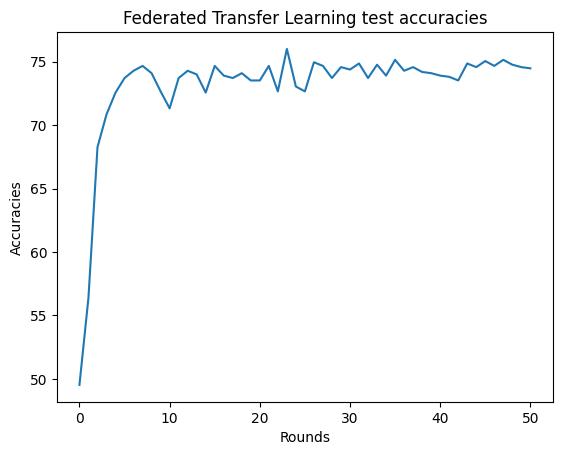

In [22]:
f = []
for i in ftl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [23]:
max(ftl_acc)

tensor(76.0038, device='cuda:0')